# Cold air composite from my own binary cold air event data
### Notes: 
also look at u and v components seperately

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pymannkendall
import eofs.xarray


## load jet winds data

In [2]:
# zg_79to04 = xr.open_dataset('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_79to04.nc')

In [3]:
# zg_05to23 = xr.open_mfdataset(['/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_05to23.nc'])

In [4]:
# zg_79to04 = zg_79to04.rename({'longitude':'lon', 'latitude':'lat', 'valid_time':'time',  'z':'z'}).squeeze('pressure_level').drop_vars(('pressure_level', 'expver', 'number'))
# zg_79to04 = zg_79to04.sel(lat=slice(90, 0))

# zg_05to23 = zg_05to23.rename({'longitude':'lon', 'latitude':'lat', 'valid_time':'time',  'z':'z'}).squeeze('pressure_level').drop_vars(('pressure_level', 'expver', 'number'))
# zg_05to23 = zg_05to23.sel(lat=slice(90, 0))

In [5]:
# zg_05to23.load()

In [6]:
# zg_79to04.load()


In [7]:
# ndjm_months = [11, 12, 1, 2]
# zg_79to04_sub = zg_79to04.sel(time=zg_79to04['time'].dt.month.isin(ndjm_months))
# zg_05to23 = zg_05to23.sel(time=zg_05to23['time'].dt.month.isin(ndjm_months))

# zg_79to04['lon'] = (zg_79to04['lon'] + 360) % 360
# zg_05to23['lon'] = (zg_05to23['lon'] + 360) % 360

# zg_79to04 = zg_79to04.sortby('lon')
# zg_05to23 = zg_05to23.sortby('lon')

In [8]:
# zg_79to04.to_netcdf('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_79to04.nc')
# zg_05to23.to_netcdf('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_05to23.nc')

In [9]:
# zg_05to23

In [10]:
# zg_79to04_coarse = zg_79to04.coarsen(lon=4).mean().coarsen(lat=4, boundary='trim').mean()
# zg_05to23_coarse = zg_05to23.coarsen(lon=4).mean().coarsen(lat=4, boundary='trim').mean()

In [11]:
# %%time
# zg_coarse = xr.concat([zg_79to04_coarse, zg_05to23_coarse], dim='time')

In [12]:
# zg_coarse['lat'] = np.floor(zg_coarse['lat'])
# zg_coarse['lon'] = np.floor(zg_coarse['lon'])

In [13]:
# zg_coarse = zg_coarse.sortby('lat')

In [14]:
# zg_coarse.to_netcdf('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_79to23.nc')

In [15]:
zg = xr.open_dataset('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_zg_79to23.nc')

In [16]:
zg

<xarray.Dataset> Size: 701MB
Dimensions:  (time: 5411, lat: 90, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 43kB 1979-01-01 1979-01-02 ... 2023-12-31
  * lat      (lat) float64 720B 0.0 1.0 2.0 3.0 4.0 ... 85.0 86.0 87.0 88.0 89.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    z        (time, lat, lon) float32 701MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-06T12:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
k06 = xr.open_mfdataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_*100to400*.nc') # before: 

In [18]:
k06

<xarray.Dataset> Size: 4GB
Dimensions:              (time: 30436, lat: 91, lon: 360)
Coordinates:
    plev                 int64 8B 100
  * lon                  (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                  (lat) float32 364B 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * time                 (time) datetime64[ns] 243kB 1940-01-01 ... 2023-04-30
Data variables:
    weighted_average_ws  (time, lat, lon) float32 4GB dask.array<chunksize=(6940, 91, 360), meta=np.ndarray>

### normalise data

In [19]:
KOCH_WS_MONTH_MEAN = k06['weighted_average_ws'].groupby('time.month').mean('time')

In [20]:
# ZG_MONTH_MEAN = zg['z'].groupby('time.month').mean('time')

In [21]:
def normalise_data(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
    
# def get_formatted_koch_imgs_normalised(row):
#     row = normalise_data(row.values.astype(float))
#     return row


def get_month_anom(row):
    row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

def get_month_anom_zg(row):
    row_month_anom = row - ZG_MONTH_MEAN.sel(month=row.time.dt.month)
    return row_month_anom

# def get_formatted_koch_imgs_normalised_month_anom_relative(row):
#     row_month_anom = row - KOCH_WS_MONTH_MEAN.sel(month=row.time.dt.month)
#     row_month_anom = normalise_data(row_month_anom.values.astype(float))
#     return row_month_anom

In [22]:
zg.load()

<xarray.Dataset> Size: 701MB
Dimensions:  (time: 5411, lat: 90, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 43kB 1979-01-01 1979-01-02 ... 2023-12-31
  * lat      (lat) float64 720B 0.0 1.0 2.0 3.0 4.0 ... 85.0 86.0 87.0 88.0 89.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    z        (time, lat, lon) float32 701MB 5.735e+04 5.736e+04 ... 5.115e+04
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-06T12:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [23]:
%%time
# zg['z_anom'] = zg['z'].groupby('time').apply(get_month_anom_zg)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 4.05 μs


In [24]:
%%time
k06['weighted_average_ws'].load();

CPU times: user 566 ms, sys: 1.13 s, total: 1.69 s
Wall time: 1.69 s


In [25]:
# %%time
# if os.path.exists('../data/jet_stream/koch_era5_jet_events_norm_40to23Mar_7levs.nc'):
#     print('loading norm data')
#     k06['jet_events_ws_norm'] = xr.open_dataarray('../data/jet_stream/koch_era5_jet_events_norm_40to23Mar_7levs.nc')
# else:
#     print('making norm data')
#     k06['jet_events_ws_norm'] = k06['weighted_average_ws'].groupby('time').apply(get_month_anom)

In [26]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc'):
    print('loading norm data')
    zg['z_anom'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc')
else:
    print('making norm data')
    zg['z_anom'] = zg['z'].groupby('time').apply(get_month_anom_zg)
    zg['z_anom'].to_netcdf('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-link/data/zg_anom_79to23Mar.nc')

loading norm data
CPU times: user 7.08 ms, sys: 27 μs, total: 7.11 ms
Wall time: 6.87 ms


In [27]:
%%time
if os.path.exists('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc'):
    print('loading norm data')
    k06['jet_events_ws_norm'] = xr.open_dataarray('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')
else:
    print('making norm data')
    k06['jet_events_ws_norm'] = k06['weighted_average_ws'].groupby('time').apply(get_month_anom)

loading norm data
CPU times: user 7.54 ms, sys: 0 ns, total: 7.54 ms
Wall time: 7.3 ms


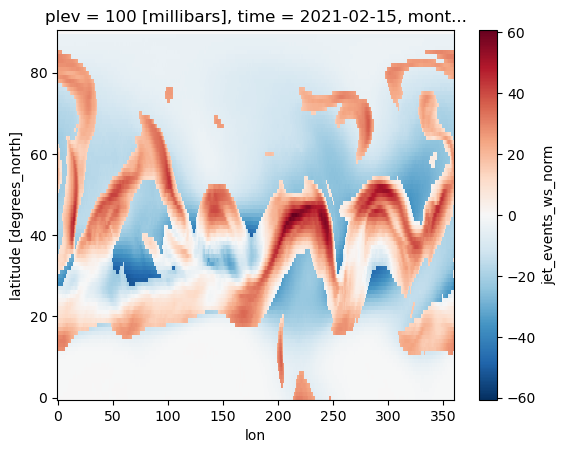

In [28]:
k06['jet_events_ws_norm'].sel(time="2021-02-15").plot()

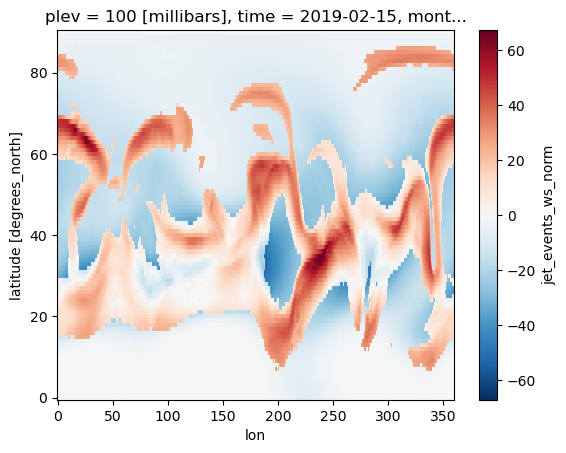

In [29]:
k06['jet_events_ws_norm'].sel(time="2019-02-15").plot()

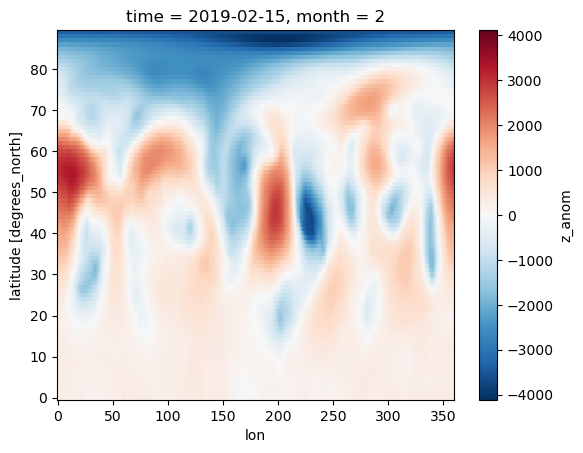

In [30]:
zg['z_anom'].sel(time="2019-02-15").plot()

In [31]:
# k06['jet_events_ws_norm'].to_netcdf('../data/jet_stream/koch_era5_jet_events_norm_40to23Mar_upperlevs.nc')

# load extreme ('persistent') cold data

In [32]:
extreme_cold_persist_thresh = xr.open_dataset('/home/thomaskeel/Dev/Research Projects/jet-extreme-weather-linkage/input_preparation/outputs/ar6_3daypersist_extreme_cold_detrend_95thpercthresh_q01.nc')

In [33]:
extreme_cold_persist_thresh['cold_air_event_CNA'].to_pandas().value_counts()

cold_air_event_CNA
0    29525
1      910
Name: count, dtype: int64

In [34]:
extreme_cold_persist_thresh.sel(time="2021-02")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 28)> Size: 672B
array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 224B 2021-02-01 2021-02-02 ... 2021-02-28
    dayofyear  (time) int64 224B 32 33 34 35 36 37 38 ... 53 54 55 56 57 58 59
    quantile   float64 8B 0.01
Dimensions without coordinates: ar6_region

In [35]:
extreme_cold_persist_thresh.sel(time="2019-02")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 28)> Size: 672B
array([[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 224B 2019-02-01 2019-02-02 ... 2019-02-28
    dayofyear  (time) int64 224B 32 33 34 35 36 37 38 ... 53 54 55 56 57 58 59
    quantile   float64 8B 0.01
Dimensions without coordinates: ar6_region

In [36]:
extreme_cold_persist_thresh.sel(time="2015-12")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3, time: 31)> Size: 744B
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]])
Coordinates:
  * time       (time) datetime64[ns] 248B 2015-12-01 2015-12-02 ... 2015-12-31
    dayofyear  (time) int64 248B 335 336 337 338 339 340 ... 361 362 363 364 365
    quantile   float64 8B 0.01
Dimensions without coordinates: ar6_region

In [37]:
extreme_cold_persist_thresh.sel(time="1994-10-31")['cold_air_event_stacked'].load()

<xarray.DataArray 'cold_air_event_stacked' (ar6_region: 3)> Size: 24B
array([0, 0, 0])
Coordinates:
    time       datetime64[ns] 8B 1994-10-31
    dayofyear  int64 8B 304
    quantile   float64 8B 0.01
Dimensions without coordinates: ar6_region

## plot composite

In [38]:
coldairevent_code_to_lookat = '001'

In [39]:
onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code_to_lookat)\
                                            ).dropna(dim='time')
onetype_coldair_event

<xarray.Dataset> Size: 66kB
Dimensions:                          (time: 630, ar6_region: 3, lon: 91, lat: 41)
Coordinates:
  * lon                              (lon) float32 364B -130.0 -129.0 ... -40.0
  * lat                              (lat) float32 164B 20.0 21.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 5kB 1940-01-28 ......
    dayofyear                        (time) int64 5kB 28 83 105 ... 109 35 99
    quantile                         float64 8B 0.01
Dimensions without coordinates: ar6_region
Data variables:
    wna_perc_coverage                (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cna_perc_coverage                (time) float64 5kB 5.243 10.11 ... 0.0 0.0
    ena_perc_coverage                (time) float64 5kB 22.09 15.99 ... 9.012
    cold_air_event_WNA               (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cold_air_event_CNA               (time) float64 5kB 0.0 0.0 0.0 ... 0.0 0.0
    cold_air_event_ENA               (time) float64 5kB 1.0 1.0 1.0 ... 1.0 1.0
    cold_air_event_stacked           (ar6_region, time) float64 15kB 0.0 ... 1.0
    cold_air_event_stacked_names     (time) object 5kB '001' '001' ... '001'
    cold_air_event_stacked_codified  (time) float64 5kB 1.0 1.0 1.0 ... 1.0 1.0

#### Optionally subset by season

In [40]:
onetype_coldair_event.groupby('time.season').sum()['cold_air_event_ENA'] # this might not be the correct season

<xarray.DataArray 'cold_air_event_ENA' (season: 4)> Size: 32B
array([314.,  15., 221.,  80.])
Coordinates:
    quantile  float64 8B 0.01
  * season    (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

In [41]:
onetype_coldair_event = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))

In [42]:
onetype_coldair_event = onetype_coldair_event.sel(time=slice("1940", "2023-03"))

## cluster groups

In [43]:
NUM_DAYS_BREAK = 1

def cluster_datetimes(dates):
    clusters = []
    current_cluster = [dates[0].data]
    
    for i in range(1, len(dates)):
        if pd.to_timedelta(int(dates[i] - dates[i - 1])).days > NUM_DAYS_BREAK:
            # Start a new cluster
            clusters.append(current_cluster)
            current_cluster = [dates[i].data]
        else:
            # Add to the current cluster
            current_cluster.append(dates[i].data)
    
    # Add the last cluster
    clusters.append(current_cluster)
    
    return clusters

cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event.time)

# Print the clusters
for i, dt_cluster in enumerate(cold_air_event_dateclusters):
    if i == 30:
        print('breaking if more than 30 values...')
        break
    print(f"Cluster {i + 1}: {dt_cluster}")


Cluster 1: [array('1940-01-28T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 2: [array('1940-12-04T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 3: [array('1941-12-21T00:00:00.000000000', dtype='datetime64[ns]'), array('1941-12-22T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 4: [array('1942-01-09T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 5: [array('1942-01-11T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 6: [array('1942-01-17T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 7: [array('1942-02-03T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 8: [array('1942-12-20T00:00:00.000000000', dtype='datetime64[ns]'), array('1942-12-21T00:00:00.000000000', dtype='datetime64[ns]'), array('1942-12-22T00:00:00.000000000', dtype='datetime64[ns]')]
Cluster 9: [array('1943-02-15T00:00:00.000000000', dtype='datetime64[ns]'), array('1943-02-16T00:00:00.000000000', dtype='datetime64[ns]'), array('1943-02-17T00:00:00.000000000', dtype='datetime64[ns]

In [44]:
print(len(cold_air_event_dateclusters), 'clusters')

219 clusters


In [45]:
k06_my_persist = k06.sel(time=onetype_coldair_event.time.data)
zg_my_persist = zg.sel(time=onetype_coldair_event.sel(time=slice("1979", "2023")).time.data)

In [46]:
k06_my_persist.time.size

314

In [47]:
k06_my_persist.load()

<xarray.Dataset> Size: 82MB
Dimensions:              (time: 314, lat: 91, lon: 360)
Coordinates:
    plev                 int64 8B 100
  * lon                  (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * lat                  (lat) float32 364B 0.0 1.0 2.0 3.0 ... 88.0 89.0 90.0
  * time                 (time) datetime64[ns] 3kB 1940-01-28 ... 2023-02-04
    month                (time) int64 3kB 1 12 12 12 1 1 1 2 ... 1 1 1 1 1 1 2
Data variables:
    weighted_average_ws  (time, lat, lon) float32 41MB 0.0 0.0 0.0 ... 0.0 0.0
    jet_events_ws_norm   (time, lat, lon) float32 41MB -0.01246 -0.012 ... 0.0

In [48]:
k06_my_persist['jet_events_ws_norm'].mean(('lat', 'lon'))

<xarray.DataArray 'jet_events_ws_norm' (time: 314)> Size: 1kB
array([-2.426592  , -2.7810168 , -1.4618351 , -1.5848014 , -0.42805037,
       -2.249886  , -1.5593657 , -3.5828526 , -0.18764773, -1.1641974 ,
       -1.649581  , -0.54685116, -0.28246897,  0.75287265, -3.5584364 ,
       -0.41331238, -0.5840038 , -1.7577437 , -0.06376983, -2.107625  ,
       -2.57162   , -2.13216   ,  0.2996118 ,  0.34372193, -0.61295927,
       -0.40795922, -0.6376167 ,  0.6086276 ,  0.3299496 ,  1.1031301 ,
        0.8458011 ,  1.2112706 ,  3.1560407 ,  0.18496768,  0.8974968 ,
       -0.7452474 , -2.411486  , -1.0058182 ,  3.6283717 ,  2.6392026 ,
        1.5469517 ,  1.3952111 , -0.7299637 ,  3.1298873 ,  0.32027757,
        0.04887093, -0.7594753 , -0.47326472,  0.7304205 ,  1.1361642 ,
        0.46896923, -0.10612402, -1.0427814 , -0.2988389 ,  0.565835  ,
       -0.4319844 , -0.15248074, -0.50264   , -1.0796587 , -1.2330905 ,
       -1.5160131 , -1.8654628 ,  3.162498  ,  2.354648  , -1.4569712 ,
       -2.5018492 ,  0.9331622 ,  1.8801926 ,  0.5451822 ,  0.8717374 ,
        0.3007572 ,  0.93023634, -0.27216524,  0.9979565 ,  1.4121377 ,
        2.1799836 ,  1.8377516 , -0.6135034 ,  1.1504887 ,  1.8296174 ,
        0.8657808 , -1.25847   , -1.7126049 , -0.9550845 ,  1.3899188 ,
        1.0261846 , -0.7424955 ,  0.61053395,  1.093819  ,  0.65896636,
       -0.3629345 ,  0.55401236,  1.5264018 ,  1.0960723 ,  2.9767687 ,
        2.4517128 , -0.05030597, -0.11834542,  1.3184667 ,  1.4008338 ,
...
        1.7136122 ,  0.32708567,  0.5769799 , -0.40760785,  1.8482841 ,
        0.8008063 ,  0.6399549 , -2.0211606 , -2.093326  ,  0.9766037 ,
        1.7797874 ,  1.6874285 ,  0.89838374,  2.7864387 ,  3.441219  ,
        1.8394042 ,  1.1118587 ,  0.78278846,  0.14799212,  1.2023958 ,
        1.7768449 , -0.9704935 , -0.21583772,  2.4706798 ,  2.3815172 ,
        1.0679935 , -0.76824254,  2.1186552 ,  2.0091772 ,  1.7053572 ,
       -0.95572025,  1.8891833 ,  2.1443458 ,  1.47098   ,  1.5478269 ,
       -1.6071073 , -0.25496796, -2.2874532 ,  2.7067533 , -0.90973145,
       -0.16541639,  0.2656281 , -1.0974823 ,  0.39220178, -0.11036999,
        2.8970435 ,  2.4570694 ,  0.8408287 ,  1.5470073 ,  0.83613497,
       -0.7176981 ,  0.16158096,  0.27935278,  0.82175004,  0.72897005,
        0.7218779 ,  0.7889102 ,  2.961238  ,  3.7974846 ,  1.8113844 ,
       -0.6689879 , -1.5332979 ,  1.0928055 ,  2.7140195 , -1.4310223 ,
        2.4298675 ,  2.0054812 , -0.05819114,  1.6276609 ,  0.06924317,
       -1.2585542 , -2.1754346 , -2.0513275 , -0.8060976 , -0.15377282,
        0.6697704 ,  1.4578482 ,  1.9839647 ,  2.2981536 , -0.4774822 ,
        1.1370894 ,  2.3027394 ,  1.3190833 ,  2.2846222 ,  3.1622689 ,
        2.493739  ,  1.5111741 ,  0.79649913,  0.29109153,  0.0187841 ,
        0.4706615 , -0.91295874, -2.2009463 , -1.3693649 , -0.2226705 ,
       -0.04895747, -2.363563  ,  0.43748334,  1.1861855 ], dtype=float32)
Coordinates:
    plev     int64 8B 100
  * time     (time) datetime64[ns] 3kB 1940-01-28 1940-12-04 ... 2023-02-04
    month    (time) int64 3kB 1 12 12 12 1 1 1 2 12 12 ... 2 12 12 1 1 1 1 1 1 2

In [49]:
# for dt_cluster in cold_air_event_dateclusters:
#     print(dt_cluster[0])

In [50]:
%%time
# with weighting
for ind, dt_cluster in enumerate(cold_air_event_dateclusters[109:]):
    if ind == 0:
        zg_my_persist_weighted = zg_my_persist.sel(time=dt_cluster).mean('time')
    else:
        zg_my_persist_weighted = xr.concat([zg_my_persist_weighted, zg_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
zg_my_persist_mean_weighted = zg_my_persist_weighted.mean('time')

CPU times: user 462 ms, sys: 12.3 ms, total: 474 ms
Wall time: 474 ms


In [51]:
%%time
# with weighting
for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
    if ind == 0:
        k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
    else:
        k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')

CPU times: user 1.12 s, sys: 216 ms, total: 1.34 s
Wall time: 1.34 s


In [52]:
zg_my_persist_weighted.load()

<xarray.Dataset> Size: 29MB
Dimensions:  (time: 110, lat: 90, lon: 360)
Coordinates:
  * lat      (lat) float64 720B 0.0 1.0 2.0 3.0 4.0 ... 85.0 86.0 87.0 88.0 89.0
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: time
Data variables:
    z        (time, lat, lon) float32 14MB 5.737e+04 5.736e+04 ... 5.19e+04
    z_anom   (time, lat, lon) float32 14MB -136.2 -141.0 ... 2.154e+03 2.155e+03

In [53]:
date_to_plot = "2018-12-28"

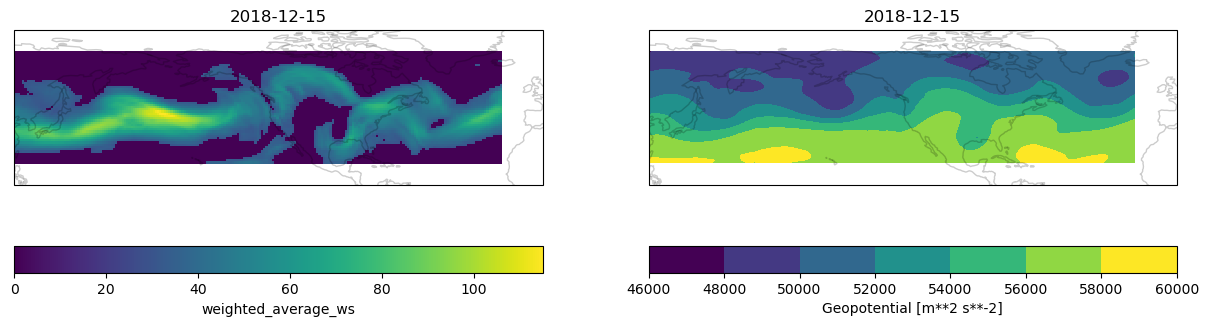

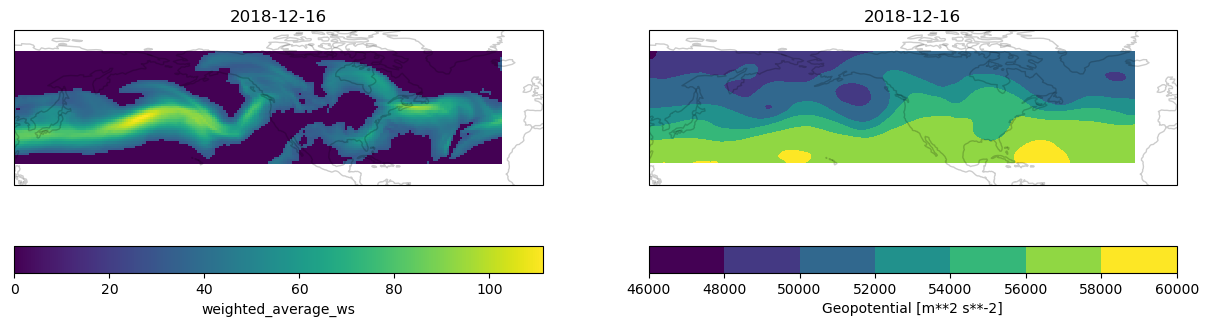

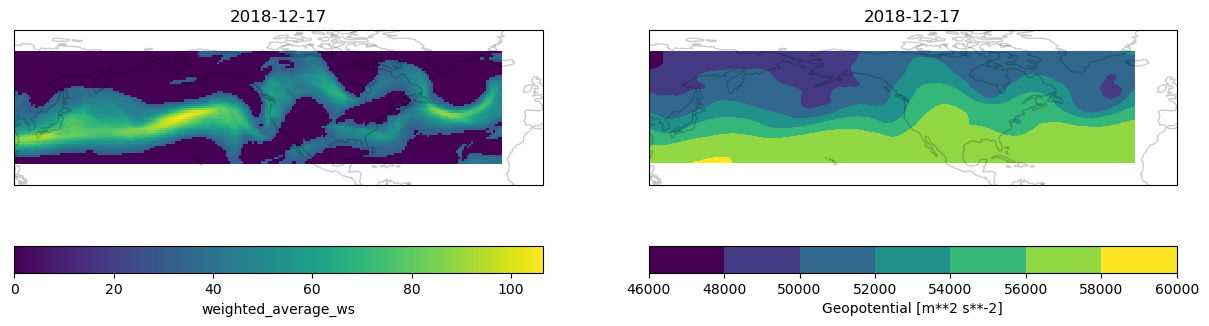

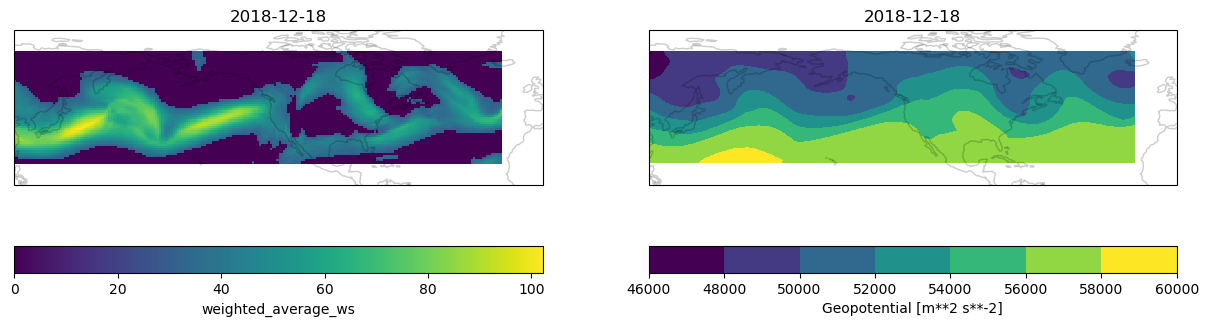

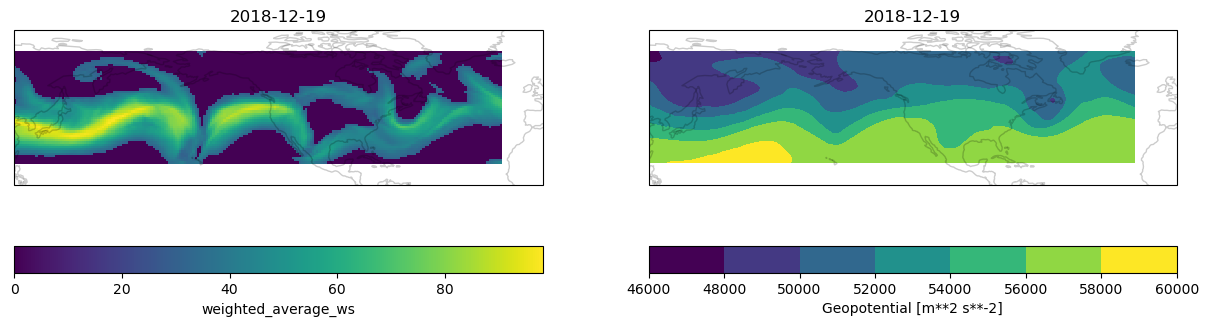

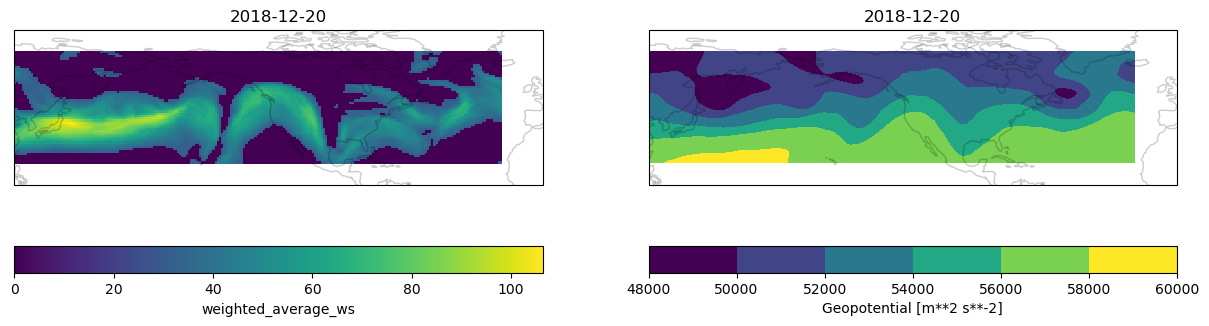

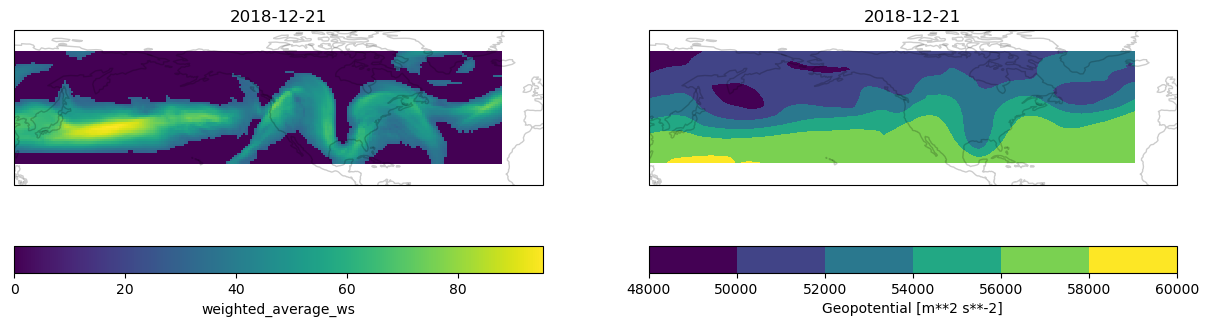

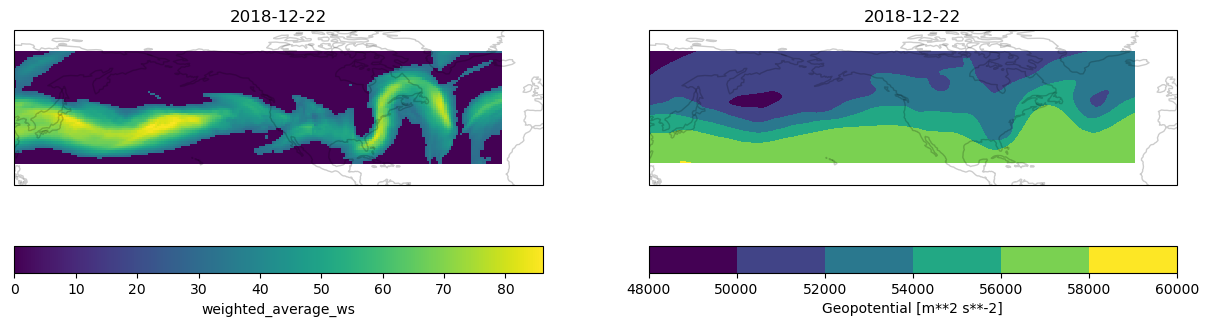

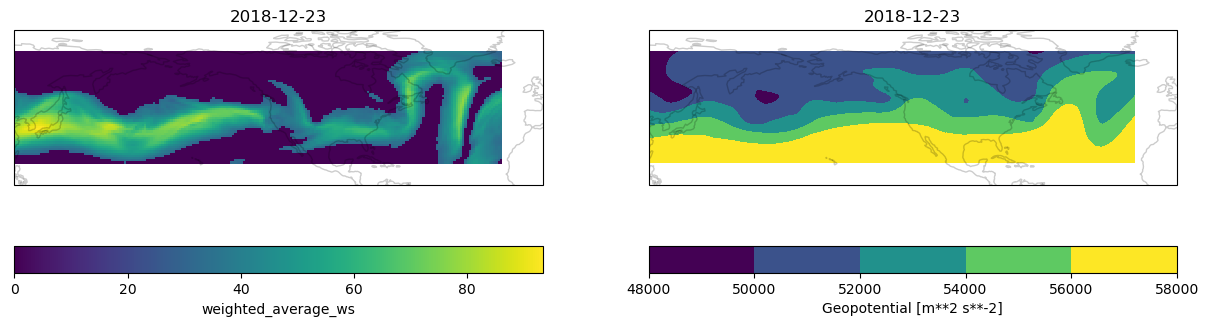

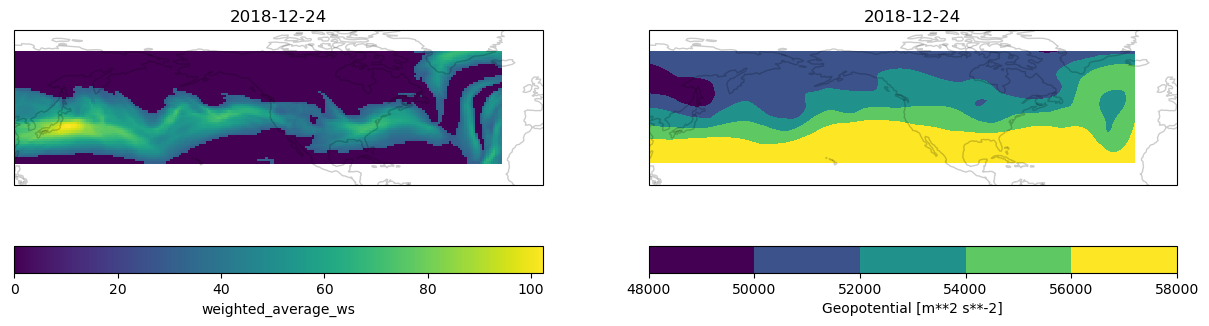

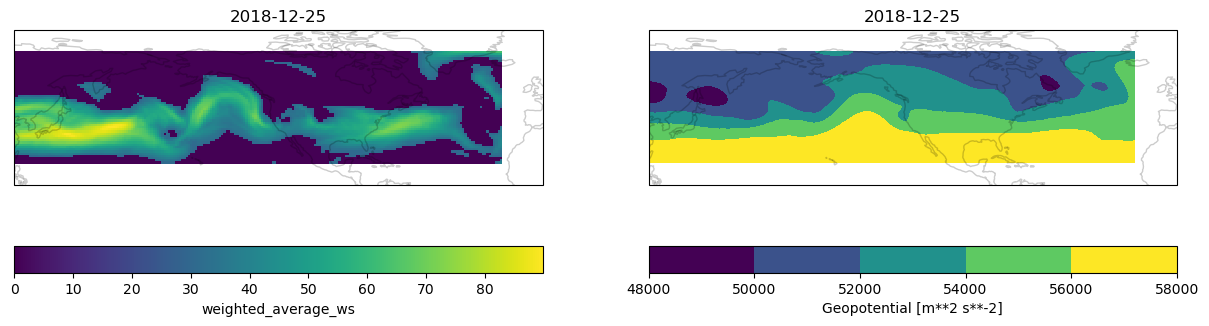

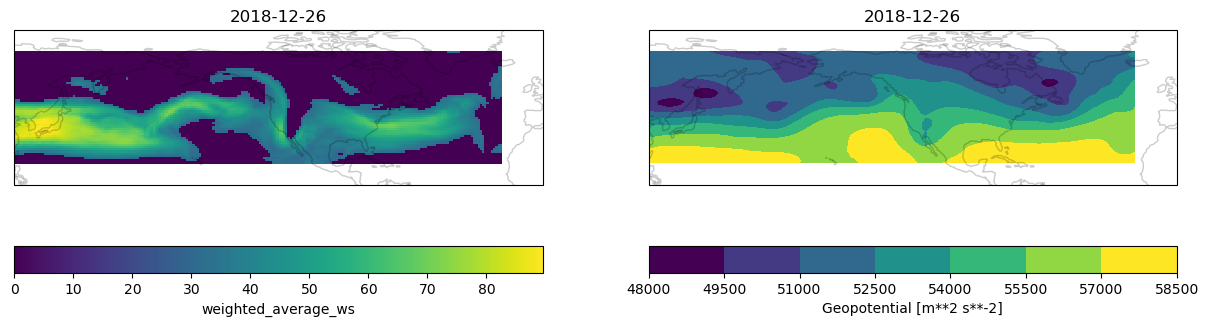

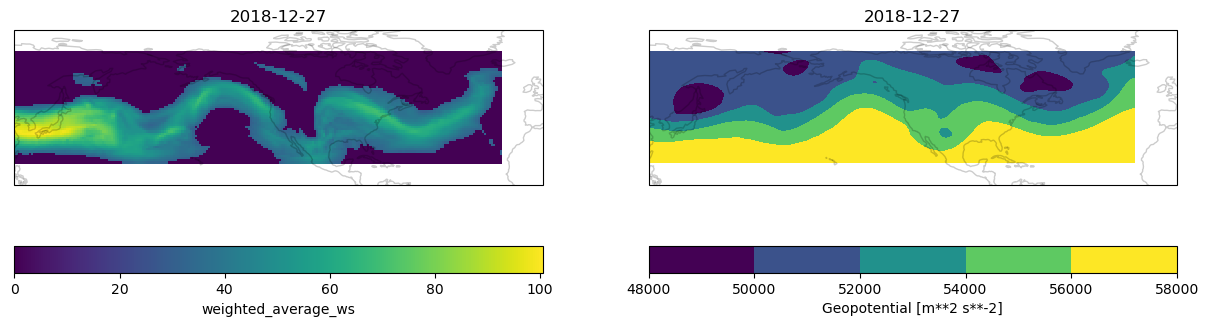

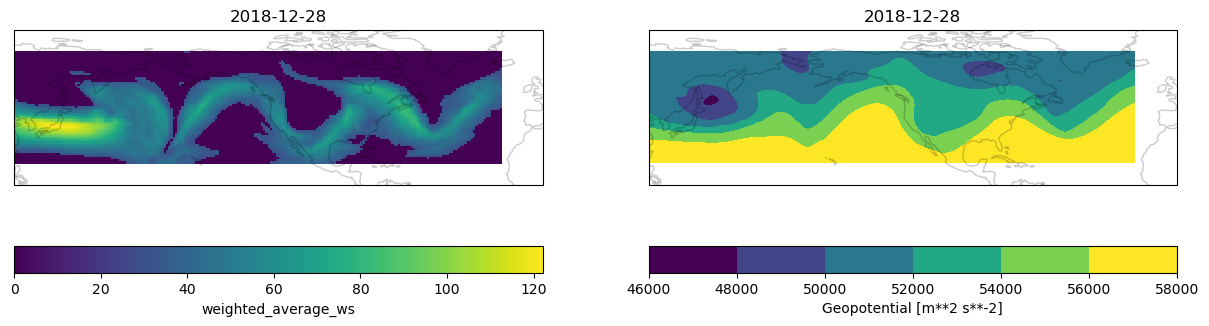

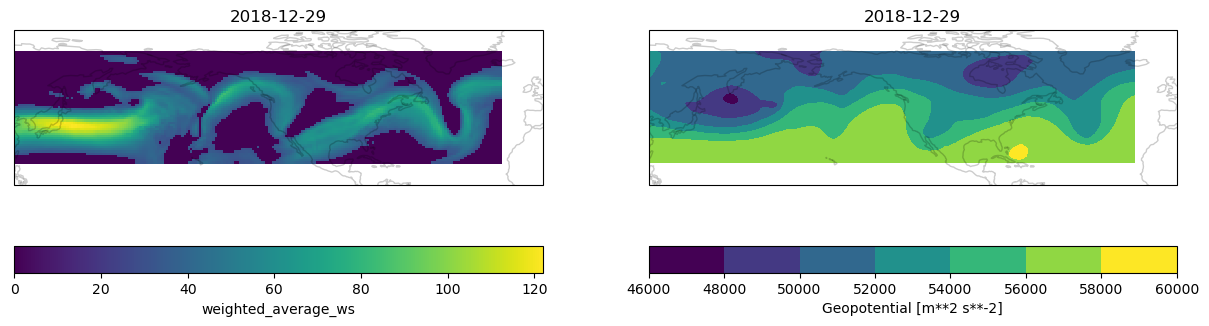

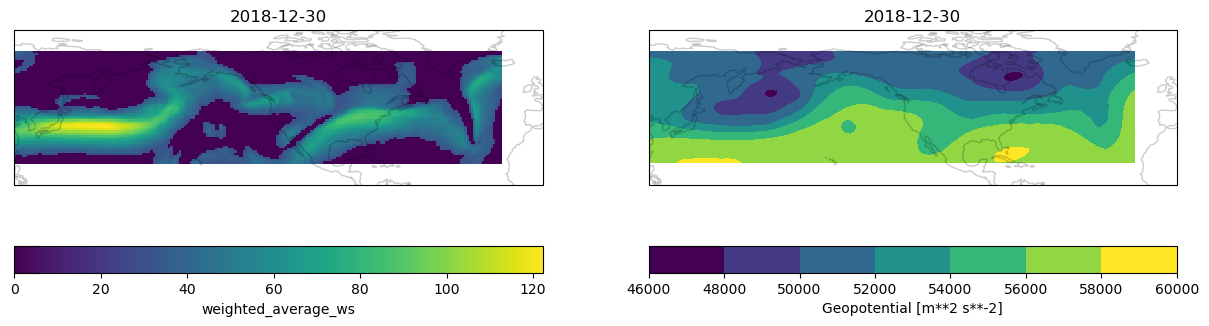

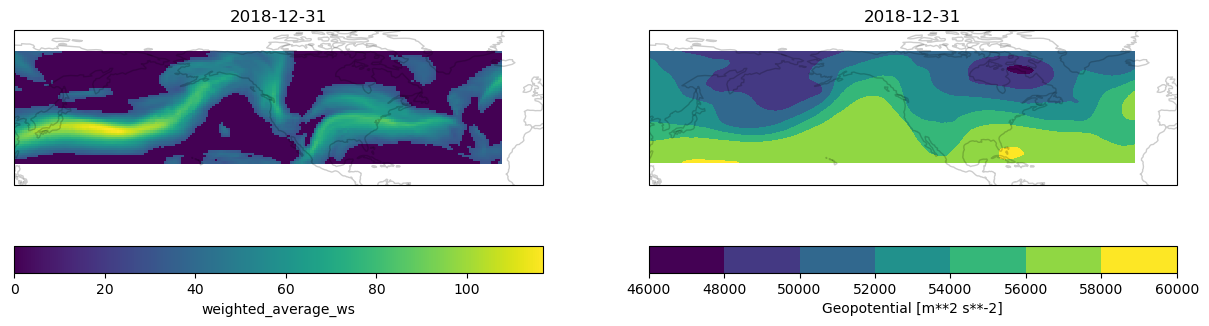

In [54]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)

for i in range(15, 32):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4), subplot_kw={'projection':proj})
    k06.sel(time=f"2018-12-{i}")['weighted_average_ws'].sel(lat=slice(20, 70), lon=slice(120, 340)).plot(ax=ax[0], transform=box_proj, cbar_kwargs={'orientation':'horizontal', 'pad':.2})
    zg.sel(time=f"2018-12-{i}")['z'].sel(lat=slice(20, 70), lon=slice(120, 340)).plot.contourf(ax=ax[1], transform=box_proj, cbar_kwargs={'orientation':'horizontal', 'pad':.2})
    for a in ax:
        a.coastlines(alpha=.2)
        a.set_title(f"2018-12-{i}")
        a.set_extent([120, 359, 10, 80], crs=box_proj)

    plt.show()

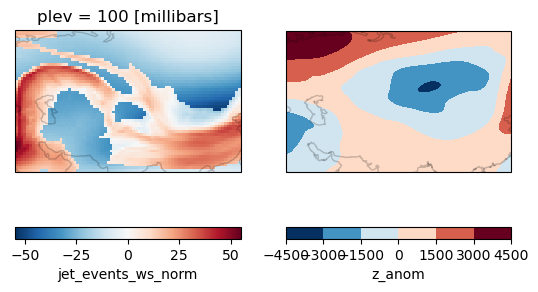

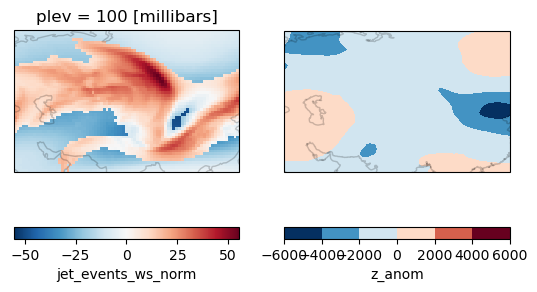

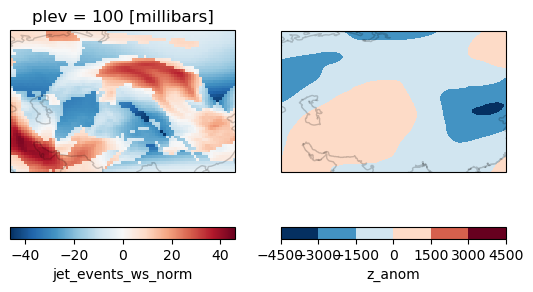

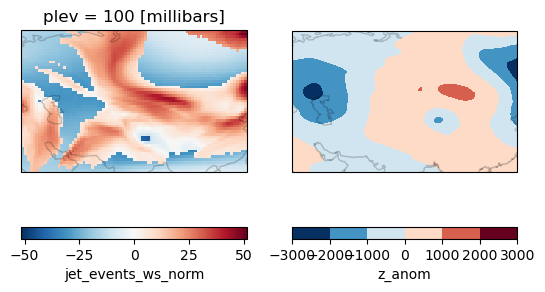

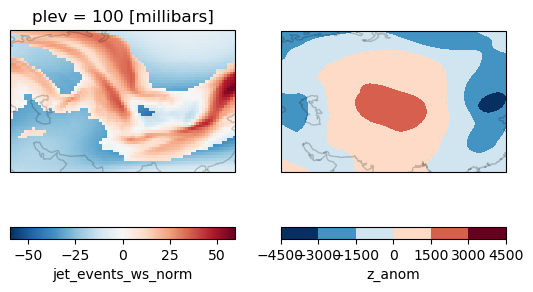

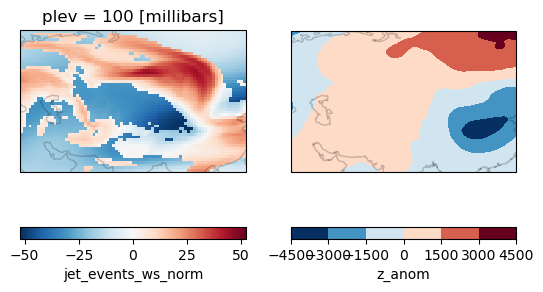

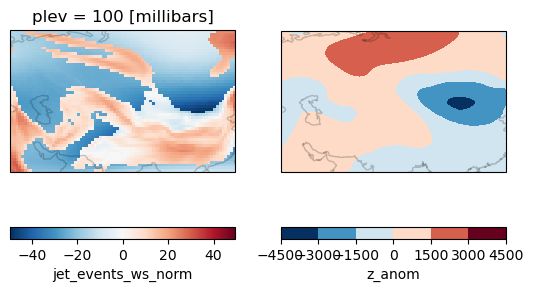

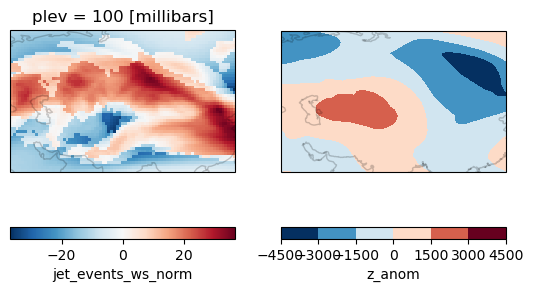

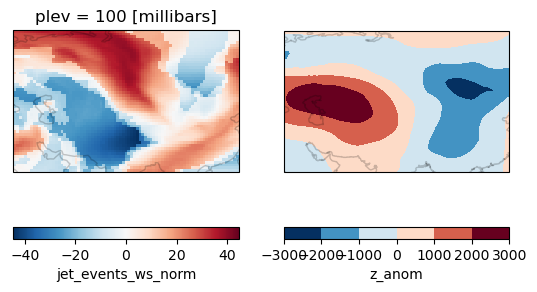

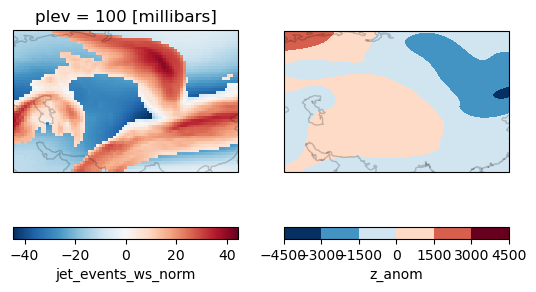

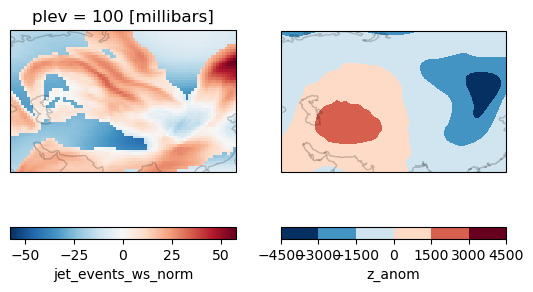

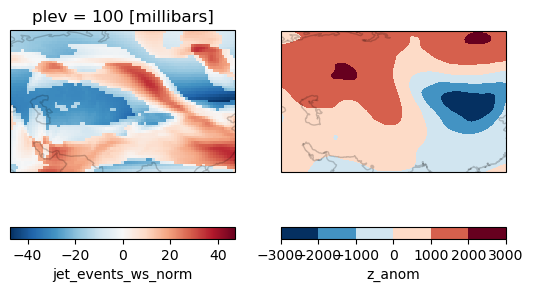

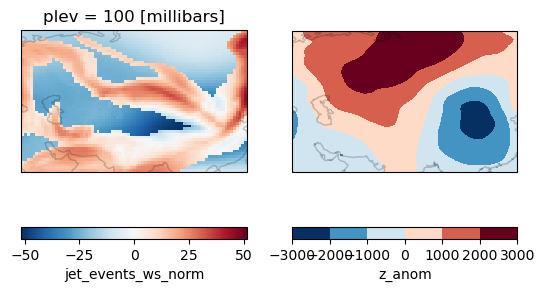

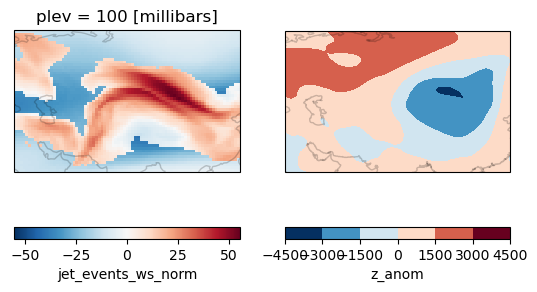

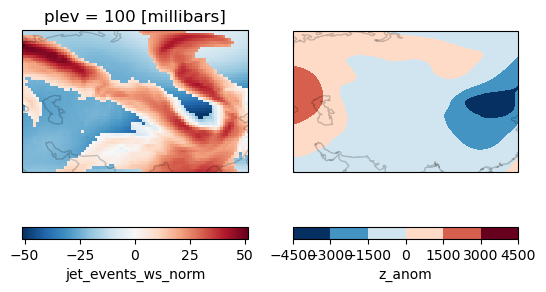

In [55]:
for i in range(15):
    fig, ax = plt.subplots(1, 2, subplot_kw={'projection':proj})
    for a in ax:
        a.coastlines(alpha=.2)
    k06_my_persist_weighted.isel(time=i)['jet_events_ws_norm'].sel(lat=slice(20, 70), lon=slice(220, 300)).plot(ax=ax[0], cbar_kwargs={'orientation':'horizontal'})
    zg_my_persist_weighted.isel(time=i)['z_anom'].sel(lat=slice(20, 70), lon=slice(220, 300)).plot.contourf(ax=ax[1], cbar_kwargs={'orientation':'horizontal'})
    plt.show()

In [56]:
%%time
# Without weighting
k06_my_persist_norm_mean = k06_my_persist['jet_events_ws_norm'].mean('time')
zg_my_persist_norm_mean = zg_my_persist['z_anom'].mean('time')

CPU times: user 34.5 ms, sys: 8.93 ms, total: 43.4 ms
Wall time: 42.2 ms


In [57]:
# for i in range(44):
#     k06_my_persist.isel(time=10+i)['weighted_average_ws_norm'].sel(lat=slice(20, 70), lon=slice(240, 300)).plot()
#     plt.show()

In [58]:
no_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == '000')\
                                            ).dropna(dim='time')

In [59]:
no_coldair_event = no_coldair_event.sel(time=slice("1940", "2023-03-01"))

In [60]:
no_coldair_event_79to23_ndjf = no_coldair_event.sel(time=slice("1979", "2023")).sel(time=no_coldair_event.sel(time=slice("1979", "2023")).time.dt.month.isin([11, 12, 1, 2]))

In [61]:
k06_my_persist_noevent = k06.sel(time=no_coldair_event.time.data)
zg_my_persist_noevent = zg.sel(time=no_coldair_event_79to23_ndjf.time.data)


In [62]:
no_coldair_event_djf = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['DJF']))
no_coldair_event_mam = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['MAM']))
no_coldair_event_jja = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['JJA']))
no_coldair_event_son = no_coldair_event.sel(time=no_coldair_event.time.dt.season.isin(['SON']))


In [63]:
k06_my_persist_noevent_djf = zg_my_persist_noevent.sel(time=zg_my_persist_noevent.time.dt.season.isin(['DJF']))
k06_my_persist_noevent_mam = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['MAM']))
k06_my_persist_noevent_jja = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['JJA']))
k06_my_persist_noevent_son = k06_my_persist_noevent.sel(time=k06_my_persist_noevent.time.dt.season.isin(['SON']))


In [64]:
k06_my_persist_noevent_djf_mean = k06_my_persist_noevent_djf['z_anom'].mean('time')
k06_my_persist_noevent_mam_mean = k06_my_persist_noevent_mam['jet_events_ws_norm'].mean('time')
k06_my_persist_noevent_jja_mean = k06_my_persist_noevent_jja['jet_events_ws_norm'].mean('time')
k06_my_persist_noevent_son_mean = k06_my_persist_noevent_son['jet_events_ws_norm'].mean('time')

In [65]:
# fig, axes = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()})
# k06_my_persist_noevent_djf_mean.fillna(0.0).plot.contourf(ax=axes[0][0], levels=np.arange(-1.6, 1.61, 0.4), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# k06_my_persist_noevent_mam_mean.fillna(0.0).plot.contourf(ax=axes[0][1], levels=np.arange(-1.6, 1.61, 0.2), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# k06_my_persist_noevent_jja_mean.fillna(0.0).plot.contourf(ax=axes[1][0], levels=np.arange(-0.6, 0.61, 0.2), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# k06_my_persist_noevent_son_mean.fillna(0.0).plot.contourf(ax=axes[1][1], levels=np.arange(-1.6, 1.61, 0.2), cmap='RdBu_r', add_colorbar=True,\
#                                                       cbar_kwargs={'shrink': 0.9, 'pad':.04, 'location':'bottom', 'label':''}, transform=ccrs.PlateCarree())
# for ax, season in zip(axes.flatten(), ['DJF', 'MAM', 'JJA', 'SON']):
#     ax.coastlines()
#     ax.set_title(season, size=14)
#     ax.set_extent([-160, -40, 20, 70])
# fig.subplots_adjust(hspace=.1)
# fig.suptitle("No Cold Event", y=0.93, size=18)
# # fig.savefig('figures/k06_000_events_byseason.png', bbox_inches='tight')

Text(0.5, 1.0, 'DJF 001 persistent cold air events')

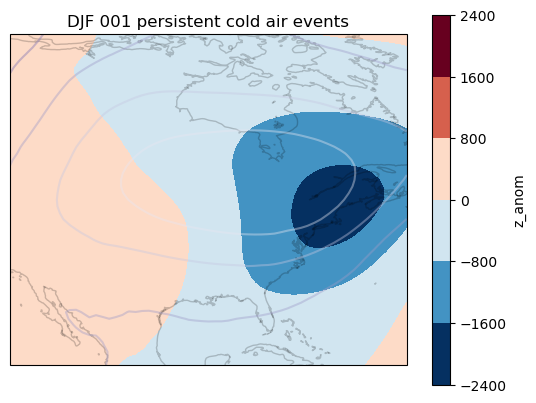

In [66]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(alpha=.2)
zg_my_persist_mean_weighted['z_anom'].sel(lat=slice(20, 70), lon=slice(240, 300)).plot.contourf()
k06_my_persist_noevent_djf_mean.sel(lat=slice(20, 70), lon=slice(240, 300)).plot.contour(cmap='Purples_r', alpha=.4)
ax.set_title(f'DJF {coldairevent_code_to_lookat} persistent cold air events')

Text(0.5, 1.0, 'DJF 001 cold air events')

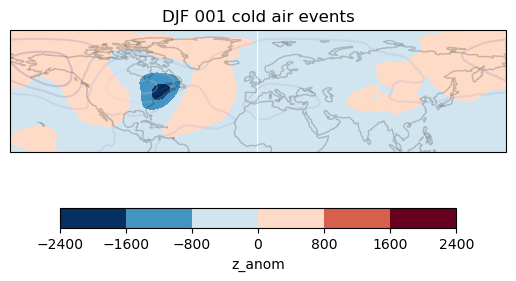

In [67]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(alpha=.2)
zg_my_persist_mean_weighted['z_anom'].plot.contourf(cbar_kwargs={'shrink': 0.8, 'location':'bottom'})
k06_my_persist_noevent_djf_mean.plot.contour(cmap='Purples_r', alpha=.2)

# ax.set_title("DJF 001 persistent cold air events")
ax.set_title(f'DJF {coldairevent_code_to_lookat} cold air events')
# fig.savefig(f'figures/composite_of_{coldairevent_code_to_lookat}events_DJF.png', bbox_inches='tight')

Text(0.5, 1.0, 'DJF 001 cold air events')

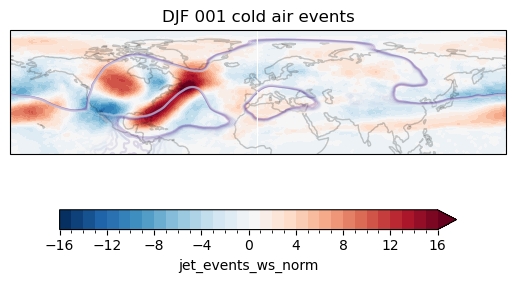

In [68]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(alpha=.2)
k06_my_persist_mean_weighted['jet_events_ws_norm'].plot.contourf(levels=np.arange(-16, 17), cbar_kwargs={'shrink': 0.8, 'location':'bottom'})
k06_my_persist_noevent_djf_mean.plot.contour(cmap='Purples_r', levels=np.arange(-1.4, 1.41, 0.4), alpha=.2)

# ax.set_title("DJF 001 persistent cold air events")
ax.set_title(f'DJF {coldairevent_code_to_lookat} cold air events')
# fig.savefig(f'figures/composite_of_{coldairevent_code_to_lookat}events_DJF.png', bbox_inches='tight')

# Look at all cold air codes 

In [69]:
all_cold_event_codes = np.unique(extreme_cold_persist_thresh['cold_air_event_stacked_names'])

In [70]:
np.unique(extreme_cold_persist_thresh['cold_air_event_stacked_names'])

array(['000', '001', '010', '011', '100', '101', '110', '111'],
      dtype='<U3')

In [71]:
THRESHOLD_FOR_CROSSHATCH = 0.66 ## 66%

In [72]:
extreme_cold_persist_thresh.load()

<xarray.Dataset> Size: 3MB
Dimensions:                          (lon: 91, lat: 41, time: 30435,
                                      ar6_region: 3)
Coordinates:
  * lon                              (lon) float32 364B -130.0 -129.0 ... -40.0
  * lat                              (lat) float32 164B 20.0 21.0 ... 59.0 60.0
  * time                             (time) datetime64[ns] 243kB 1940-01-01 ....
    dayofyear                        (time) int64 243kB 1 2 3 4 ... 118 119 120
    quantile                         float64 8B 0.01
Dimensions without coordinates: ar6_region
Data variables:
    wna_perc_coverage                (time) float64 243kB 0.0 0.0 ... 0.0 0.0
    cna_perc_coverage                (time) float64 243kB 0.3745 9.363 ... 0.0
    ena_perc_coverage                (time) float64 243kB 6.105 8.43 ... 0.0 0.0
    cold_air_event_WNA               (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0
    cold_air_event_CNA               (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0
    cold_air_event_ENA               (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0
    cold_air_event_stacked           (ar6_region, time) int64 730kB 0 0 ... 0 0
    cold_air_event_stacked_names     (time) <U3 365kB '000' '000' ... '000'
    cold_air_event_stacked_codified  (time) int64 243kB 0 0 0 0 0 ... 0 0 0 0 0

In [73]:
k06['jet_events_ws_norm'].load()

<xarray.DataArray 'jet_events_ws_norm' (time: 30436, lat: 91, lon: 360)> Size: 4GB
array([[[-1.24614993e-02, -1.19974883e-02,  0.00000000e+00, ...,
         -7.29230642e-02, -6.03944175e-02, -2.42605731e-02],
        [-1.22112492e-02, -1.19161941e-02, -1.15531795e-02, ...,
         -1.19825140e-01, -8.33399519e-02, -3.62406075e-02],
        [-4.74795140e-02, -2.37672366e-02, -2.39607897e-02, ...,
         -1.70513049e-01, -9.73332450e-02, -7.22845495e-02],
        ...,
        [ 2.71288967e+01,  2.71026917e+01,  2.70755234e+01, ...,
          2.72547359e+01,  2.72174416e+01,  2.71914196e+01],
        [-4.44260168e+00, -4.45535707e+00, -4.42207861e+00, ...,
         -4.45025587e+00, -4.46304274e+00, -4.44129086e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.24614993e-02, -1.19974883e-02,  0.00000000e+00, ...,
         -7.29230642e-02, -6.03944175e-02, -2.42605731e-02],
        [-1.22112492e-02, -1.19161941e-02, -1.15531795e-02, ...,
         -1.19825140e-01, -8.33399519e-02, -3.62406075e-02],
        [-4.74795140e-02, -2.37672366e-02, -2.39607897e-02, ...,
         -1.70513049e-01, -9.73332450e-02, -7.22845495e-02],
...
         -2.15358734e+00, -2.15337873e+00, -2.16509533e+00],
        [-2.19014359e+00, -2.20171738e+00, -2.21336079e+00, ...,
         -2.22685742e+00, -2.19076252e+00, -2.19045877e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.15303564e+00, -2.15290308e+00, -2.14088893e+00, ...,
         -2.15358734e+00, -2.15337873e+00, -2.16509533e+00],
        [-2.19014359e+00, -2.20171738e+00, -2.21336079e+00, ...,
         -2.22685742e+00, -2.19076252e+00, -2.19045877e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],
      dtype=float32)
Coordinates:
    plev     int64 8B 100
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat      (lat) float32 364B 0.0 1.0 2.0 3.0 4.0 ... 86.0 87.0 88.0 89.0 90.0
  * time     (time) datetime64[ns] 243kB 1940-01-01 1940-01-02 ... 2023-04-30
    month    (time) int64 243kB 1 1 1 1 1 1 1 1 1 1 1 ... 4 4 4 4 4 4 4 4 4 4 4

In [74]:
extreme_cold_persist_thresh = extreme_cold_persist_thresh.sel(time=slice("1940", "2023-03-01"))

In [75]:
def make_k06_season_ds(season_composite_ds, season):
    for coldairevent_code in all_cold_event_codes:
        # if coldairevent_code == '101':
        #     continue
        onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code)\
                                                ).dropna(dim='time')
        onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([season]))
        if onetype_coldair_event_djf.time.size < 1:
            continue
        print(coldairevent_code)
        cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event_djf.time)
        k06_my_persist = k06.sel(time=onetype_coldair_event_djf.time.data)
        for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
            if ind == 0:
                k06_my_persist_weighted = k06_my_persist.sel(time=dt_cluster).mean('time')
            else:
                k06_my_persist_weighted = xr.concat([k06_my_persist_weighted, k06_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
        if 'time' not in k06_my_persist_weighted.dims:
            print('time not in dims')
            k06_my_persist_weighted = k06_my_persist_weighted.expand_dims('time')
        
        k06_my_persist_mean_weighted = k06_my_persist_weighted.mean('time')
        sign_crosshatching = np.sign(k06_my_persist_weighted['jet_events_ws_norm']) == np.sign(k06_my_persist_mean_weighted['jet_events_ws_norm'])
        sign_crosshatching_time_mean = sign_crosshatching.sum(('time'))
        sign_crosshatching_time_mean_mask = (sign_crosshatching_time_mean / k06_my_persist_weighted.time.size) > THRESHOLD_FOR_CROSSHATCH
        
        season_composite_ds[coldairevent_code] = k06_my_persist_mean_weighted['jet_events_ws_norm']
        season_composite_ds[f'{coldairevent_code}_mask'] = sign_crosshatching_time_mean_mask
    return season_composite_ds

def make_zg_season_ds(season_composite_ds, season):
    for coldairevent_code in all_cold_event_codes:
        # if coldairevent_code == '101':
        #     continue
        onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code)\
                                                ).dropna(dim='time')
        onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([season]))
        if onetype_coldair_event_djf.time.size < 1:
            continue
        print(coldairevent_code)
        cold_air_event_dateclusters = cluster_datetimes(onetype_coldair_event_djf.time)
        zg_my_persist = zg.sel(time=onetype_coldair_event_djf.time.data)
        for ind, dt_cluster in enumerate(cold_air_event_dateclusters):
            if ind == 0:
                zg_my_persist_weighted = zg_my_persist.sel(time=dt_cluster).mean('time')
            else:
                zg_my_persist_weighted = xr.concat([zg_my_persist_weighted, zg_my_persist.sel(time=dt_cluster).mean('time')], dim='time')
        if 'time' not in zg_my_persist_weighted.dims:
            print('time not in dims')
            zg_my_persist_weighted = zg_my_persist_weighted.expand_dims('time')
        
        zg_my_persist_mean_weighted = zg_my_persist_weighted.mean('time')
        sign_crosshatching = np.sign(zg_my_persist_weighted['z_anom']) == np.sign(zg_my_persist_mean_weighted['z_anom'])
        sign_crosshatching_time_mean = sign_crosshatching.sum(('time'))
        sign_crosshatching_time_mean_mask = (sign_crosshatching_time_mean / zg_my_persist_weighted.time.size) > THRESHOLD_FOR_CROSSHATCH
        
        season_composite_ds[coldairevent_code] = zg_my_persist_mean_weighted['z_anom']
        season_composite_ds[f'{coldairevent_code}_mask'] = sign_crosshatching_time_mean_mask
    return season_composite_ds

In [76]:
if not os.path.exists('outputs/all_zg_composites.nc'):
    print('making zg composites')
    djf_zg_composites = xr.Dataset()
    mam_zg_composites = xr.Dataset()
    jja_zg_composites = xr.Dataset()
    son_zg_composites = xr.Dataset()
    
    djf_zh_composites = make_zg_season_ds(djf_zg_composites, 'DJF')
    mam_zh_composites = make_zg_season_ds(mam_zg_composites, 'MAM')
    jja_zh_composites = make_zg_season_ds(jja_zg_composites, 'JJA')
    son_zh_composites = make_zg_season_ds(son_zg_composites, 'SON')
    all_zg_composites = xr.concat([djf_zg_composites, mam_zg_composites, jja_zg_composites, son_zg_composites], dim='season')
    all_zg_composites['season'] = ['DJF', 'MAM', 'JJA', 'SON']
    all_zg_composites.to_netcdf('outputs/all_zg_composites.nc')
else:
    print('loading zg composites')
    all_zg_composites = xr.open_dataset('outputs/all_zg_composites.nc')

loading zg composites


In [77]:
if not os.path.exists('outputs/all_k06_composites_100to400.nc'):
    print('making k06 composites')
    djf_k06_composites = xr.Dataset()
    mam_k06_composites = xr.Dataset()
    jja_k06_composites = xr.Dataset()
    son_k06_composites = xr.Dataset()
    
    djf_k06_composites = make_k06_season_ds(djf_k06_composites, 'DJF')
    mam_k06_composites = make_k06_season_ds(mam_k06_composites, 'MAM')
    jja_k06_composites = make_k06_season_ds(jja_k06_composites, 'JJA')
    son_k06_composites = make_k06_season_ds(son_k06_composites, 'SON')
    all_k06_composites = xr.concat([djf_k06_composites, mam_k06_composites, jja_k06_composites, son_k06_composites], dim='season')
    all_k06_composites['season'] = ['DJF', 'MAM', 'JJA', 'SON']
    all_k06_composites.to_netcdf('outputs/all_k06_composites_100to400.nc')
else:
    print('loading k06 composites')
    all_k06_composites = xr.open_dataset('outputs/all_k06_composites_100to400.nc')

loading k06 composites


In [78]:
all_k06_composites.load()

<xarray.Dataset> Size: 8MB
Dimensions:   (lon: 360, lat: 91, season: 4)
Coordinates:
    plev      int64 8B 100
  * lon       (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat       (lat) float32 364B 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * season    (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
Data variables: (12/16)
    000       (season, lat, lon) float32 524kB -0.01546 -0.008646 ... 0.0 0.0
    000_mask  (season, lat, lon) bool 131kB True True True ... True True True
    001       (season, lat, lon) float32 524kB -0.02067 -0.01231 ... 0.0 0.0
    001_mask  (season, lat, lon) bool 131kB True True False ... True True True
    010       (season, lat, lon) float32 524kB -0.02012 -0.0123 ... 0.0 0.0
    010_mask  (season, lat, lon) bool 131kB True True False ... True True True
    ...        ...
    110       (season, lat, lon) float32 524kB -0.02053 -0.01232 ... 0.0 0.0
    110_mask  (season, lat, lon) bool 131kB True True True ... True True True
    111       (season, lat, lon) float32 524kB -0.01979 -0.01236 ... 0.0 0.0
    111_mask  (season, lat, lon) float64 1MB 1.0 1.0 1.0 0.0 ... 1.0 1.0 1.0 1.0
    101       (season, lat, lon) float32 524kB nan nan nan nan ... nan nan nan
    101_mask  (season, lat, lon) float64 1MB nan nan nan nan ... nan nan nan nan

In [79]:
all_zg_composites.load()

<xarray.Dataset> Size: 9MB
Dimensions:   (lon: 360, lat: 91, season: 4)
Coordinates:
  * lon       (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat       (lat) float32 364B 90.0 89.0 88.0 87.0 86.0 ... 3.0 2.0 1.0 0.0
  * season    (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
Data variables: (12/16)
    000       (season, lat, lon) float32 524kB 6.58 6.58 6.58 ... 2.245 2.41
    000_mask  (season, lat, lon) bool 131kB False False False ... False False
    001       (season, lat, lon) float32 524kB -12.03 -12.03 ... 13.88 12.72
    001_mask  (season, lat, lon) bool 131kB False False False ... False False
    010       (season, lat, lon) float32 524kB 23.21 23.21 ... -27.33 -26.1
    010_mask  (season, lat, lon) bool 131kB False False False ... False False
    ...        ...
    110       (season, lat, lon) float32 524kB 239.9 239.9 ... -47.07 -47.24
    110_mask  (season, lat, lon) float64 1MB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    111       (season, lat, lon) float32 524kB -930.3 -930.3 -930.3 ... nan nan
    111_mask  (season, lat, lon) float64 1MB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    101       (season, lat, lon) float32 524kB nan nan nan nan ... nan nan nan
    101_mask  (season, lat, lon) float64 1MB nan nan nan nan ... nan nan nan nan

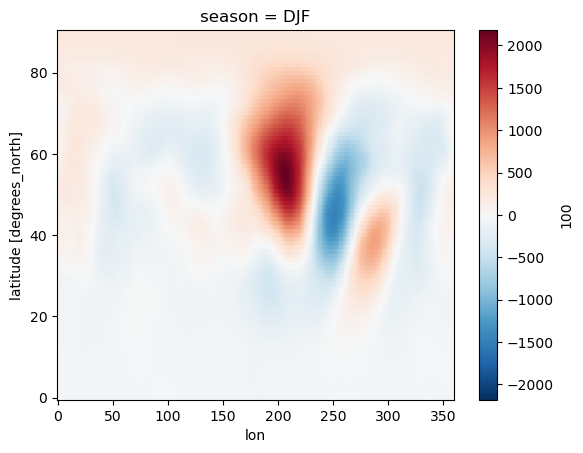

In [80]:
all_zg_composites['100'].sel(season='DJF').plot()

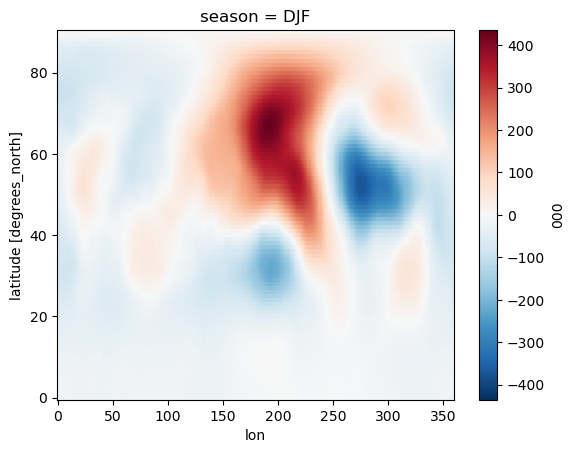

In [81]:
all_zg_composites['000'].sel(season='DJF').plot()

In [82]:
djf_cold_event_codes = ['001', '010', '100', '011', '110', '111']

In [83]:
djf_mean = zg['z_anom'].sel(time=zg.time.dt.season.isin(['DJF'])).mean('time')
son_mean = zg['z_anom'].sel(time=zg.time.dt.season.isin(['SON'])).mean('time')

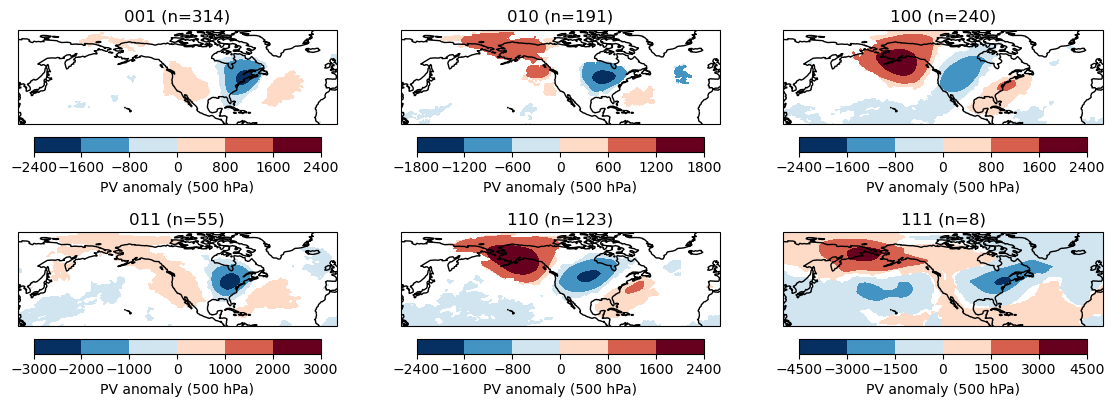

In [84]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True, subplot_kw={'projection':proj})
for ind, ax in enumerate(axes.reshape(-1)):
    try:
        cao_code = djf_cold_event_codes[ind]
    except:
        continue
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == cao_code)\
                                            ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    onetype_coldair_event_djf = onetype_coldair_event_djf.sel(time=slice("1940", "2023-03-01"))
    
    # djf_mean.plot.contour(colors='purple', transform=box_proj, linewidths=1, ax=ax, alpha=.15)

    all_zg_composites_66perc = all_zg_composites[cao_code].sel(season='DJF').where(all_zg_composites[f'{cao_code}_mask'].sel(season='DJF'))
    all_zg_composites_66perc.plot.contourf(cmap='RdBu_r', transform=box_proj, ax=ax, add_colorbar=True, cbar_kwargs={'shrink': 0.9, 'pad':.04, 'orientation':'horizontal', 'label': f'PV anomaly (500 hPa)'})
#     levels=np.arange(48000, 59000, 1000)
    ax.set_title(f"{cao_code} (n={onetype_coldair_event_djf.time.size})")
    ax.coastlines()
    ax.set_extent([120, 359, 10, 80], crs=box_proj)
fig.subplots_adjust(hspace=-.4)
# fig.savefig('figures/djf_pv_composites_all_codes.png', dpi=200,  bbox_inches='tight')

In [85]:
djf_mean = k06['weighted_average_ws'].sel(time=k06.time.dt.season.isin(['DJF'])).mean('time')
son_mean = k06['weighted_average_ws'].sel(time=k06.time.dt.season.isin(['SON'])).mean('time')

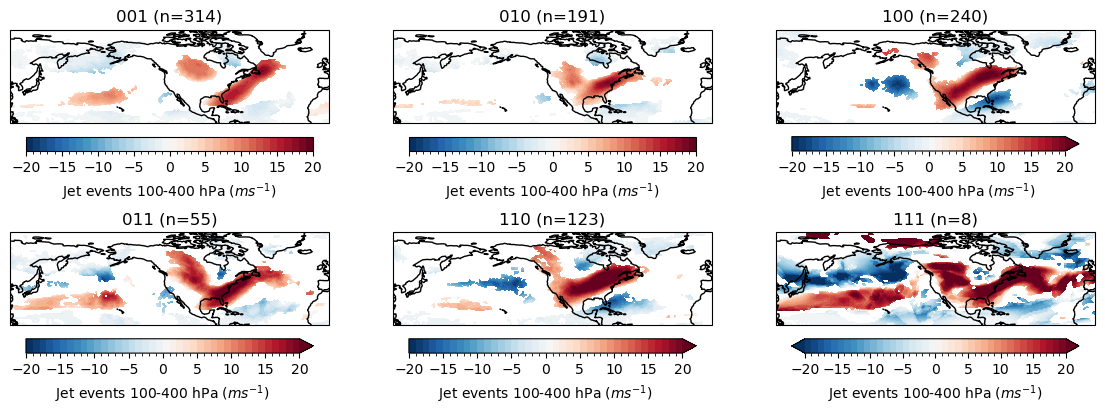

In [86]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True, sharey=True, subplot_kw={'projection':proj})
mps = r"($ms^{-1}$)"
for ind, ax in enumerate(axes.reshape(-1)):
    cao_code = djf_cold_event_codes[ind]
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == cao_code)\
                                            ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    # all_k06_composites[cao_code].plot(ax=ax, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'orientation':'horizontal', 'label': f'Jet events 100-850 hPa {mps}'})
    all_k06_composites_66perc = all_k06_composites[cao_code].sel(season='DJF').where(all_k06_composites[f'{cao_code}_mask'].sel(season='DJF'))
    all_k06_composites_66perc.plot.contourf(levels=np.arange(-20, 21), transform=box_proj, center=0, ax=ax, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.9, 'pad':.04, 'orientation':'horizontal', 'label': f'Jet events 100-400 hPa {mps}'})
    ax.set_title(f"{cao_code} (n={onetype_coldair_event_djf.time.size})")
    ax.coastlines()
    ax.set_extent([120, 359, 10, 80], crs=box_proj)
fig.subplots_adjust(hspace=-.4)
# fig.savefig('figures/djf_koch_composites_all_codes.png', dpi=200,  bbox_inches='tight')

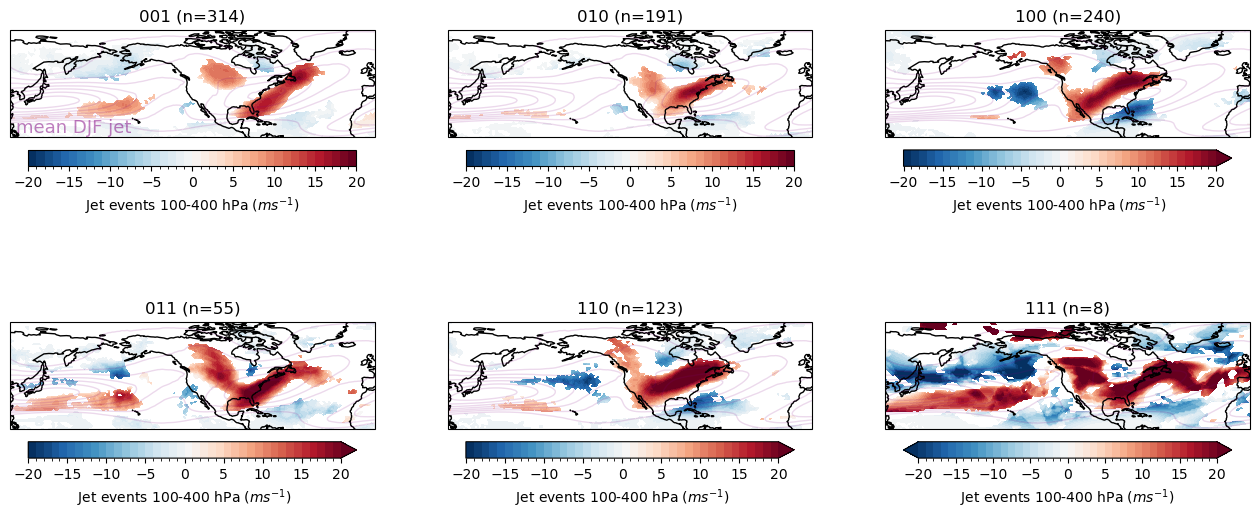

In [87]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True, subplot_kw={'projection':proj})
mps = r"($ms^{-1}$)"
for ind, ax in enumerate(axes.reshape(-1)):
    cao_code = djf_cold_event_codes[ind]
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == cao_code)\
                                            ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))
    # k06_my_persist_noevent_djf_mean.plot.contour(cmap='Purples_r', levels=np.arange(-1.4, 1.41, 0.4), ax=ax, alpha=.3)
    djf_mean.plot.contour(colors='purple', transform=box_proj, levels=np.arange(0, 80, 10), linewidths=1, ax=ax, alpha=.15)
    all_k06_composites_66perc = all_k06_composites[cao_code].sel(season='DJF').where(all_k06_composites[f'{cao_code}_mask'].sel(season='DJF'))
    all_k06_composites_66perc.plot.contourf(levels=np.arange(-20, 21), transform=box_proj,  center=0, ax=ax, cmap='RdBu_r', add_colorbar=True, cbar_kwargs={'shrink': 0.9, 'pad':.04, 'orientation':'horizontal', 'label': f'Jet events 100-400 hPa {mps}'})
    ax.set_title(f"{cao_code} (n={onetype_coldair_event_djf.time.size})")
    ax.coastlines()
    ax.set_extent([120, 359, 10, 80], crs=box_proj)
axes[0][0].text(s="mean DJF jet", x=-56, y=12.4, color='purple', alpha=.5, size=13)
fig.subplots_adjust(hspace=-.1)
# fig.savefig('figures/djf_koch_composites_all_codes_w_meanstate.png', dpi=300,  bbox_inches='tight')

## Change time lags

In [88]:
coldairevent_code = '001'
onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code)\
                                        ).dropna(dim='time')

In [89]:
onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin(['DJF']))


In [90]:
LAG_IN_DAYS = 1

In [91]:
onetype_coldair_event_lagged_times = onetype_coldair_event_djf.time - np.timedelta64(LAG_IN_DAYS, 'D') # onetype_coldair_event.time.dt.season.isin(['DJF'])

In [92]:
cold_air_event_dateclusters_lagged = cluster_datetimes(onetype_coldair_event_lagged_times)

In [93]:
no_coldair_event_lagged_times_79to23_ndjf = onetype_coldair_event_lagged_times.sel(time=slice("1979", "2023")).sel(time=onetype_coldair_event_lagged_times.sel(time=slice("1979", "2023")).time.dt.month.isin([11, 12, 1, 2]))

In [94]:
zg_my_persist_lagged = zg.sel(time=no_coldair_event_lagged_times_79to23_ndjf)

In [95]:
%%time
# with weighting
for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged[109:]):
    if ind == 0:
        zg_my_persist_lagged_weighted = zg_my_persist_lagged.sel(time=dt_cluster).mean('time')
    else:
        zg_my_persist_lagged_weighted = xr.concat([zg_my_persist_lagged_weighted, zg_my_persist_lagged.sel(time=dt_cluster).mean('time')], dim='time')
zg_my_persist_lagged_mean_weighted = zg_my_persist_lagged_weighted.mean('time')

CPU times: user 894 ms, sys: 48.3 ms, total: 942 ms
Wall time: 941 ms


In [96]:
%%time
# Without weighting
zg_my_persist_lagged_norm_mean = zg_my_persist_lagged['z_anom'].mean('time')

CPU times: user 39.7 ms, sys: 8.82 ms, total: 48.5 ms
Wall time: 46.7 ms


In [97]:
sign_crosshatching_lagged = np.sign(zg_my_persist_lagged_weighted['z_anom']) == np.sign(zg_my_persist_lagged_mean_weighted['z_anom'])
sign_crosshatching_lagged_time_mean = sign_crosshatching_lagged.sum(('time'))
sign_crosshatching_lagged_time_mean_mask = (sign_crosshatching_lagged_time_mean / zg_my_persist_lagged_weighted.time.size)  > 0.66

Text(0.5, 1.0, 'DJF 001 cold air events')

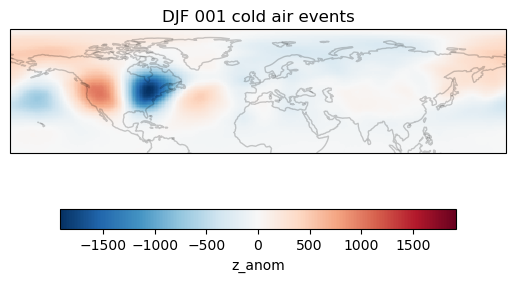

In [98]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(alpha=.2)
zg_my_persist_lagged_mean_weighted['z_anom'].plot(cbar_kwargs={'shrink': 0.8, 'location':'bottom'})
# ax.set_title("DJF 001 persistent cold air events")
ax.set_title(f'DJF {coldairevent_code_to_lookat} cold air events')
# fig.savefig(f'figures/composite_of_{coldairevent_code_to_lookat}events_DJF.png', bbox_inches='tight')

Text(0.5, 1.0, 'DJF 001 persistent cold air events <66% correct sign')

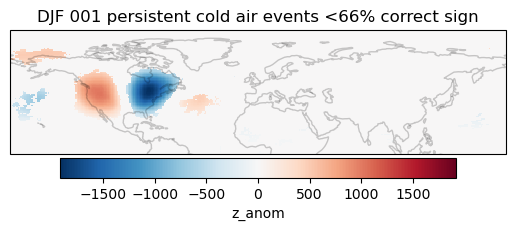

In [99]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines(alpha=.2)
(zg_my_persist_lagged_mean_weighted['z_anom'] * sign_crosshatching_lagged_time_mean_mask).plot(cbar_kwargs={'shrink': 0.8, 'pad':0.01, 'location':'bottom'})
# ax.set_title("DJF 001 persistent cold air events")
ax.set_title(f'DJF {coldairevent_code_to_lookat} persistent cold air events <66% correct sign')


In [100]:
coldairevent_code_to_lookat = '100'
onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldairevent_code_to_lookat)\
                                        ).dropna(dim='time')

In [101]:
SEASON_TO_USE = 'DJF'
onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))


In [102]:
### REMOVED BECUASE I DO NOT HAVE COMPLETE ZG DATA
# %%time
# time_lags = np.arange(-20, 21) # -20 to +20 days
# proj = ccrs.PlateCarree(central_longitude=180)
# box_proj = ccrs.PlateCarree(central_longitude=0)

# trough_vals_100 = []
# npj_vals_100 = []

# trough_vals_010 = []
# npj_vals_010 = []

# trough_vals_001 = []
# npj_vals_001 = []

# for lag in time_lags:
#     print(f'lag of {lag} days')
#     # 100
#     onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == '100')\
#                                         ).dropna(dim='time')

#     type100_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))
#     type100_coldair_event_lagged_times = type100_coldair_event_djf.time + np.timedelta64(lag, 'D')
#     type100_coldair_event_lagged_times = type100_coldair_event_lagged_times[type100_coldair_event_lagged_times > zg.time[0]]
#     type100_coldair_event_lagged_times = type100_coldair_event_lagged_times[type100_coldair_event_lagged_times < zg.time[-1]]

    
#     # 010
#     onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == '010')\
#                                         ).dropna(dim='time')
#     type010_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))
#     type010_coldair_event_lagged_times = type010_coldair_event_djf.time + np.timedelta64(lag, 'D')
#     type010_coldair_event_lagged_times = type010_coldair_event_lagged_times[type010_coldair_event_lagged_times > zg.time[0]]
#     type010_coldair_event_lagged_times = type010_coldair_event_lagged_times[type010_coldair_event_lagged_times < zg.time[-1]]

    
#     # 001
#     onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == '001')\
#                                         ).dropna(dim='time')
#     type001_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))
#     type001_coldair_event_lagged_times = type001_coldair_event_djf.time + np.timedelta64(lag, 'D')
#     type001_coldair_event_lagged_times = type001_coldair_event_lagged_times[type001_coldair_event_lagged_times > zg.time[0]]
#     type001_coldair_event_lagged_times = type001_coldair_event_lagged_times[type001_coldair_event_lagged_times < zg.time[-1]]

    
#     cold_air_event_dateclusters_lagged_100 = cluster_datetimes(type100_coldair_event_lagged_times)
#     cold_air_event_dateclusters_lagged_010 = cluster_datetimes(type010_coldair_event_lagged_times)
#     cold_air_event_dateclusters_lagged_001 = cluster_datetimes(type001_coldair_event_lagged_times)
    
#     zg_my_persist_lagged_100 = zg.sel(time=type100_coldair_event_lagged_times)
#     zg_my_persist_lagged_010 = zg.sel(time=type010_coldair_event_lagged_times)
#     zg_my_persist_lagged_001 = zg.sel(time=type001_coldair_event_lagged_times)
#     # with weighting
#     for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged_100):
#         if ind == 0:
#             zg_my_persist_lagged_weighted_100 = zg_my_persist_lagged_100.sel(time=dt_cluster).mean('time')
#         else:
#             zg_my_persist_lagged_weighted_100 = xr.concat([zg_my_persist_lagged_weighted_100, zg_my_persist_lagged_100.sel(time=dt_cluster).mean('time')], dim='time')

#     zg_my_persist_lagged_mean_weighted_100 = zg_my_persist_lagged_weighted_100.mean('time')
    
    
#     # with weighting
#     for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged_010):
#         if ind == 0:
#             zg_my_persist_lagged_weighted_010 = zg_my_persist_lagged_010.sel(time=dt_cluster).mean('time')
#         else:
#             zg_my_persist_lagged_weighted_010 = xr.concat([zg_my_persist_lagged_weighted_010, zg_my_persist_lagged_010.sel(time=dt_cluster).mean('time')], dim='time')
#     zg_my_persist_lagged_mean_weighted_010 = zg_my_persist_lagged_weighted_010.mean('time')
    
#     # with weighting
#     for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged_001):
#         if ind == 0:
#             zg_my_persist_lagged_weighted_001 = zg_my_persist_lagged_001.sel(time=dt_cluster).mean('time')
#         else:
#             zg_my_persist_lagged_weighted_001 = xr.concat([zg_my_persist_lagged_weighted_001, zg_my_persist_lagged_001.sel(time=dt_cluster).mean('time')], dim='time')
#     zg_my_persist_lagged_mean_weighted_001 = zg_my_persist_lagged_weighted_001.mean('time')
    
    
#     trough_vals_100.append(abs((zg_my_persist_lagged_mean_weighted_100['z_anom']).sel(lat=slice(20, 70), lon=slice(230, 310)).fillna(0.0)).mean().data)
#     npj_vals_100.append(abs((zg_my_persist_lagged_mean_weighted_100['z_anom']).sel(lat=slice(20, 70), lon=slice(120, 230)).fillna(0.0)).mean().data)

#     trough_vals_010.append(abs((zg_my_persist_lagged_mean_weighted_010['z_anom']).sel(lat=slice(20, 70), lon=slice(230, 310)).fillna(0.0)).mean().data)
#     npj_vals_010.append(abs((zg_my_persist_lagged_mean_weighted_010['z_anom']).sel(lat=slice(20, 70), lon=slice(120, 230)).fillna(0.0)).mean().data)

#     trough_vals_001.append(abs((zg_my_persist_lagged_mean_weighted_001['z_anom']).sel(lat=slice(20, 70), lon=slice(230, 310)).fillna(0.0)).mean().data)
#     npj_vals_001.append(abs((zg_my_persist_lagged_mean_weighted_001['z_anom']).sel(lat=slice(20, 70), lon=slice(120, 230)).fillna(0.0)).mean().data)


In [104]:
# trough_df = pd.DataFrame([trough_vals_100, trough_vals_010, trough_vals_001]).T
# npj_df = pd.DataFrame([npj_vals_100, npj_vals_010, npj_vals_001]).T

In [105]:
# trough_df.columns = ['100', '010', '001']
# npj_df.columns = ['100', '010', '001']

In [106]:
# plt.plot(npj_df, '--')

In [107]:
# plt.plot(trough_df)

In [108]:
set2_cmap = sns.color_palette("Set2", 4)
set2_cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [109]:
# trough_df.to_csv('outputs/trough_zg_df.csv', index=False)
# npj_df.to_csv('outputs/npj_zg_df.csv', index=False)

In [110]:
trough_df = pd.read_csv('outputs/trough_df_zg.csv')
npj_df = pd.read_csv('outputs/npj_df_zg.csv')

In [111]:
trough_df_jet = pd.read_csv('outputs/trough_df_k06.csv')
npj_df_jet = pd.read_csv('outputs/npj_df_k06.csv')

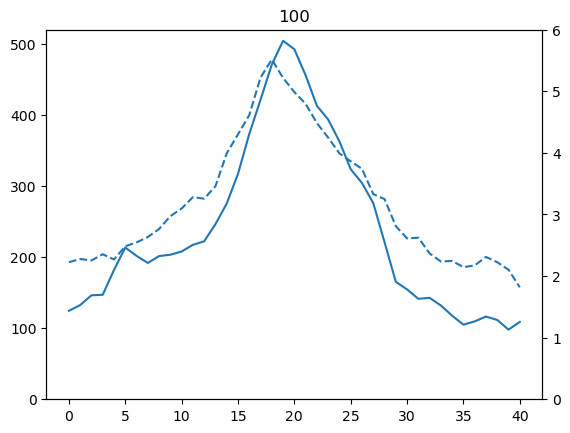

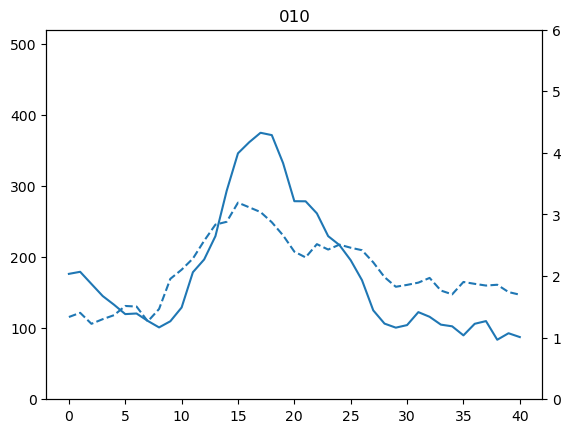

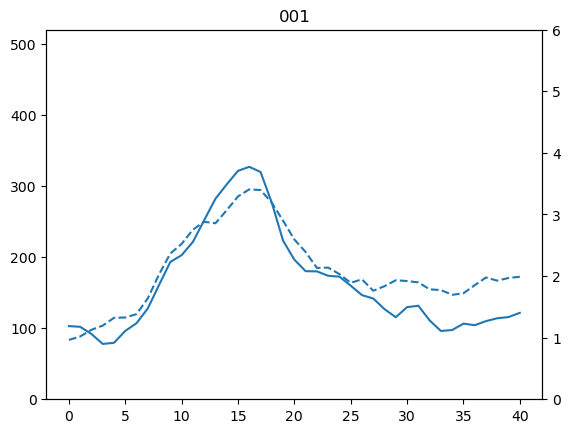

In [112]:
for col in trough_df.columns:
    fig, ax = plt.subplots(1)
    ax.plot(npj_df[col])
    ax2 = ax.twinx()
    ax2.plot(npj_df_jet[col], '--')
    ax.set_title(col)
    ax.set_ylim(0, 520)
    ax2.set_ylim(0, 6)
    plt.show()

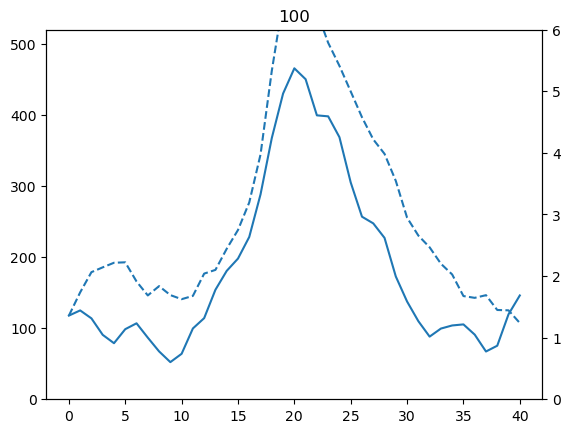

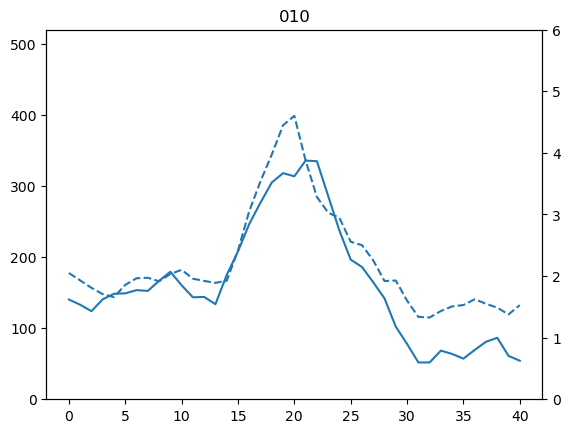

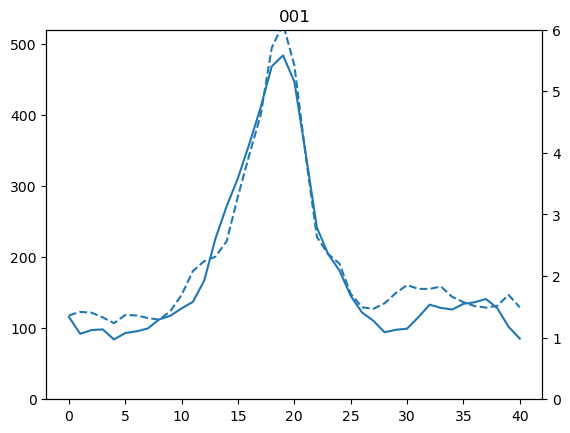

In [113]:
for col in trough_df.columns:
    fig, ax = plt.subplots(1)
    ax.plot(trough_df[col])
    ax2 = ax.twinx()
    ax2.plot(trough_df_jet[col], '--')
    ax.set_title(col)
    ax.set_ylim(0, 520)
    ax2.set_ylim(0, 6)
    plt.show()

In [114]:
trough_prop_df = (trough_df / trough_df.max())
npj_prop_df = (npj_df / npj_df.max())


In [115]:
trough_prop_df_jet = (trough_df_jet / trough_df_jet.max())
npj_prop_df_jet = (npj_df_jet / npj_df_jet.max())

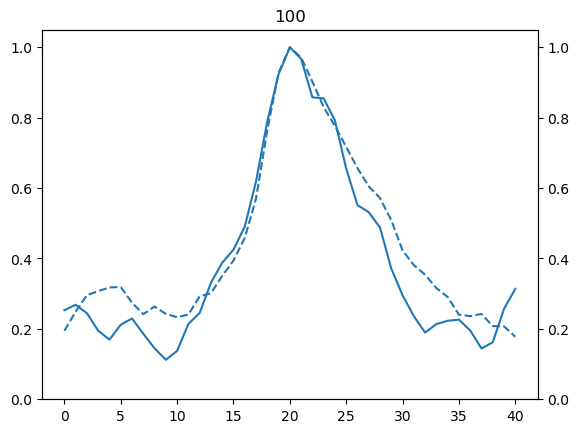

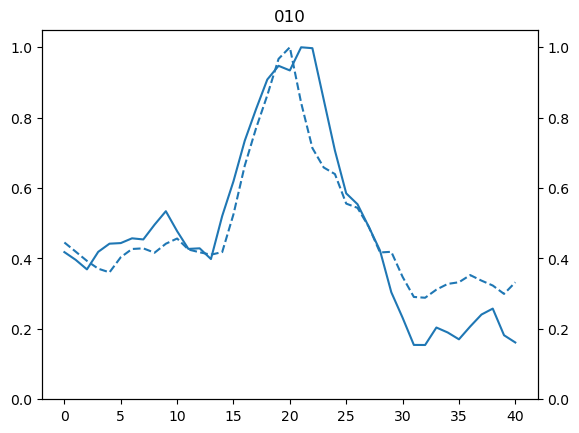

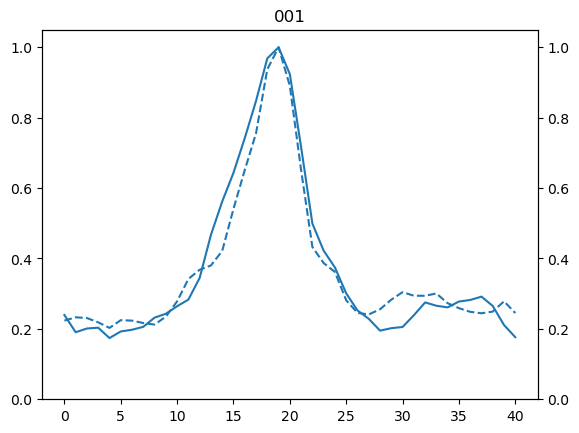

In [116]:
for col in trough_prop_df.columns:
    fig, ax = plt.subplots(1)
    ax.plot(trough_prop_df[col])
    ax2 = ax.twinx()
    ax2.plot(trough_prop_df_jet[col], '--')
    ax.set_title(col)
    ax.set_ylim(0, 1.05)
    ax2.set_ylim(0, 1.05)
    plt.show()

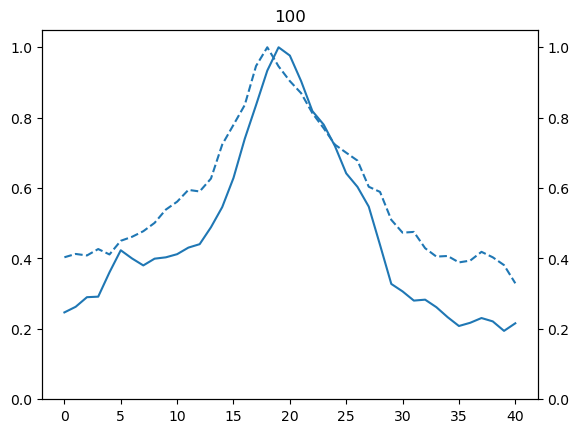

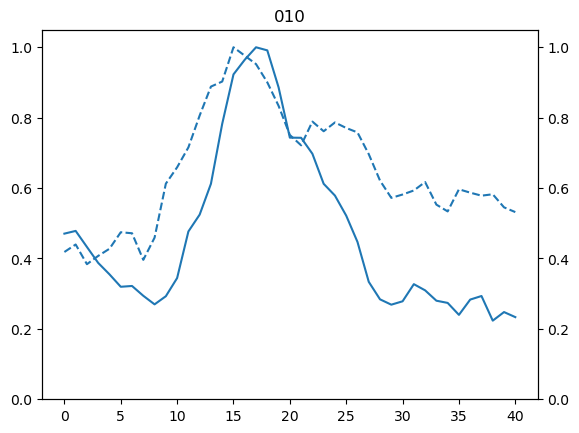

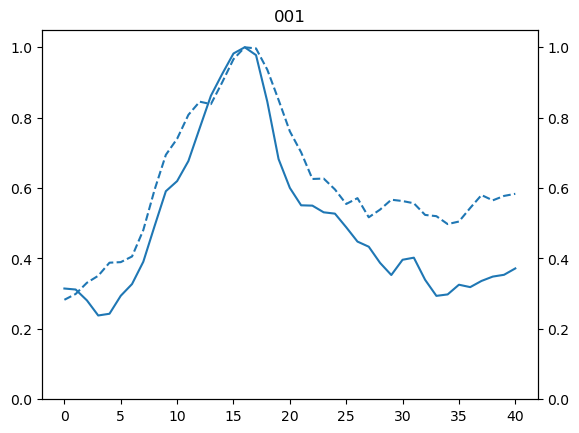

In [117]:
for col in npj_prop_df.columns:
    fig, ax = plt.subplots(1)
    ax.plot(npj_prop_df[col])
    ax2 = ax.twinx()
    ax2.plot(npj_prop_df_jet[col], '--')
    ax.set_title(col)
    ax.set_ylim(0, 1.05)
    ax2.set_ylim(0, 1.05)
    plt.show()

In [118]:
SEASON_TO_USE = 'DJF'

In [119]:
SAME_SIGN_THRESHOLD = .66

In [120]:
def plot_lag_composite_zg(coldair_type, lag, ax, vmin, vmax, cbar=False):
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldair_type)\
                                        ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))
    onetype_coldair_event_lagged_times = onetype_coldair_event_djf.time + np.timedelta64(lag, 'D')
    onetype_coldair_event_lagged_times = onetype_coldair_event_lagged_times[onetype_coldair_event_lagged_times > zg.time[0]]

    cold_air_event_dateclusters_lagged = cluster_datetimes(onetype_coldair_event_lagged_times)
    
    zg_my_persist_lagged = zg.sel(time=onetype_coldair_event_lagged_times)
    
    for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged):
        if ind == 0:
            zg_my_persist_lagged_weighted = zg_my_persist_lagged.sel(time=dt_cluster).mean('time')
        else:
            zg_my_persist_lagged_weighted = xr.concat([zg_my_persist_lagged_weighted, zg_my_persist_lagged.sel(time=dt_cluster).mean('time')], dim='time')
    zg_my_persist_lagged_mean_weighted = zg_my_persist_lagged_weighted.mean('time')
    zg_my_persist_lagged_norm_mean = zg_my_persist_lagged['z_anom'].mean('time')
    sign_crosshatching_lagged = np.sign(zg_my_persist_lagged_weighted['z_anom']) == np.sign(zg_my_persist_lagged_mean_weighted['z_anom'])
    sign_crosshatching_lagged_time_mean = sign_crosshatching_lagged.sum(('time'))
    sign_crosshatching_lagged_time_mean_mask = (sign_crosshatching_lagged_time_mean / zg_my_persist_lagged_weighted.time.size)  > SAME_SIGN_THRESHOLD 
    if cbar:
        (zg_my_persist_lagged_mean_weighted['z_anom']\
         * sign_crosshatching_lagged_time_mean_mask).plot(\
                            ax=ax, transform=box_proj, vmin=vmin, vmax=vmax, cmap='RdBu_r',\
                            cbar_kwargs={'shrink': 0.8, 'location':'bottom',\
                                        'label': 'Geopotential anomaly ($m$)'})
    else:
        (zg_my_persist_lagged_mean_weighted['z_anom']\
         * sign_crosshatching_lagged_time_mean_mask).plot(\
                            ax=ax, transform=box_proj, vmin=vmin, vmax=vmax, cmap='RdBu_r',\
                            add_colorbar=False)
    return ax



In [121]:
def plot_lag_composite(coldair_type, lag, ax, cbar=False):
    onetype_coldair_event = extreme_cold_persist_thresh.where((extreme_cold_persist_thresh['cold_air_event_stacked_names'] == coldair_type)\
                                        ).dropna(dim='time')
    onetype_coldair_event_djf = onetype_coldair_event.sel(time=onetype_coldair_event.time.dt.season.isin([SEASON_TO_USE]))
    onetype_coldair_event_lagged_times = onetype_coldair_event_djf.time + np.timedelta64(lag, 'D')
    onetype_coldair_event_lagged_times = onetype_coldair_event_lagged_times[onetype_coldair_event_lagged_times > k06.time[0]]

    cold_air_event_dateclusters_lagged = cluster_datetimes(onetype_coldair_event_lagged_times)
    
    k06_my_persist_lagged = k06.sel(time=onetype_coldair_event_lagged_times)
    
    for ind, dt_cluster in enumerate(cold_air_event_dateclusters_lagged):
        if ind == 0:
            k06_my_persist_lagged_weighted = k06_my_persist_lagged.sel(time=dt_cluster).mean('time')
        else:
            k06_my_persist_lagged_weighted = xr.concat([k06_my_persist_lagged_weighted, k06_my_persist_lagged.sel(time=dt_cluster).mean('time')], dim='time')
    k06_my_persist_lagged_mean_weighted = k06_my_persist_lagged_weighted.mean('time')
    k06_my_persist_lagged_norm_mean = k06_my_persist_lagged['jet_events_ws_norm'].mean('time')
    sign_crosshatching_lagged = np.sign(k06_my_persist_lagged_weighted['jet_events_ws_norm']) == np.sign(k06_my_persist_lagged_mean_weighted['jet_events_ws_norm'])
    sign_crosshatching_lagged_time_mean = sign_crosshatching_lagged.sum(('time'))
    sign_crosshatching_lagged_time_mean_mask = (sign_crosshatching_lagged_time_mean / k06_my_persist_lagged_weighted.time.size)  > SAME_SIGN_THRESHOLD
    if cbar:
        (k06_my_persist_lagged_mean_weighted['jet_events_ws_norm']\
         * sign_crosshatching_lagged_time_mean_mask).plot(\
                            ax=ax, transform=box_proj, vmin=-18, vmax=18, cmap='RdBu_r',\
                            cbar_kwargs={'shrink': 0.8, 'location':'bottom',\
                                        'label': 'Jet event anomaly ($ms^{-1}$)'})
    else:
        (k06_my_persist_lagged_mean_weighted['jet_events_ws_norm']\
         * sign_crosshatching_lagged_time_mean_mask).plot(\
                            ax=ax, transform=box_proj, vmin=-18, vmax=18, cmap='RdBu_r',\
                            add_colorbar=False)
    return ax


season: DJF


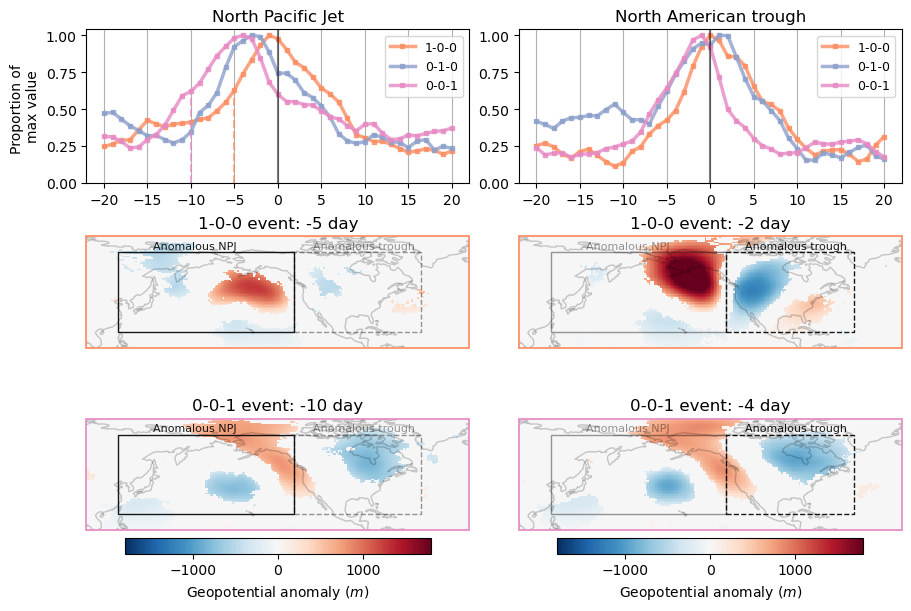

In [122]:
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)

# ONSETS as determined by above 0.6 of max threshold
npj_onset_100 = -5
npj_onset_001 = -10
trough_onset_100 = -2
trough_onset_001 = -4


fig = plt.figure(figsize=(9, 6), constrained_layout=True) #9, 5 best ratio
gs = plt.GridSpec(3, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax4 = fig.add_subplot(gs[1, 1], projection=proj, sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], projection=proj, sharex=ax3, sharey=ax3)
ax6 = fig.add_subplot(gs[2, 1], projection=proj, sharex=ax3, sharey=ax3)

# ax1.plot(np.arange(-20, 21), np.array(npj_vals_000) / np.array(npj_vals_000).max(), alpha=.6, color=set2_cmap[0])
# ax2.plot(np.arange(-20, 21), np.array(trough_vals_000) / np.array(trough_vals_000).max(), alpha=.6, color=set2_cmap[0])
# linestyles_to_use = ['-', '--', '-.']
for ind, col in enumerate(trough_prop_df.columns):
    ax1.plot(np.arange(-20, 21), npj_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8, marker='s', markersize=3)
    ax2.plot(np.arange(-20, 21), trough_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8 , marker='s', markersize=3)

ax1.vlines(x=npj_onset_100, ymin=0., ymax=npj_prop_df.iloc[20+npj_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=npj_onset_001, ymin=0., ymax=npj_prop_df.iloc[20+npj_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=trough_onset_100, ymin=0., ymax=trough_prop_df.iloc[20+trough_onset_100]['100'],\
#            color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=trough_onset_001, ymin=0., ymax=trough_prop_df.iloc[20+trough_onset_001]['001'],\
#            color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)


ax1.set_title("North Pacific Jet")
ax2.set_title("North American trough")
ax1.set_ylabel("Proportion of \nmax value", size=10)

for ind, ax in enumerate([ax1, ax2]):
    ax.grid(axis='x')
    ax.axvline(0, color='k', alpha=.5)
    ax.legend(['1-0-0', '0-1-0', '0-0-1'], fontsize=9)
    # ax.axhline(0.6, xmin=-0.025, xmax=0.025, alpha=.3, color='m', clip_on=False)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_ylim(0.0, 1.04)
    ax.set_xlabel("")


### MAP PLOTS

print('season:', SEASON_TO_USE)
plot_lag_composite_zg('100', npj_onset_100, ax3, vmin=-1800, vmax=1800)
plot_lag_composite_zg('100', trough_onset_100, ax4, vmin=-1800, vmax=1800)
plot_lag_composite_zg('001', npj_onset_100, ax5, vmin=-1800, vmax=1800, cbar=True)
plot_lag_composite_zg('001', trough_onset_001, ax6, vmin=-1800, vmax=1800, cbar=True)

ax3.set_title(f"1-0-0 event: {npj_onset_100} day")#, color=set2_cmap[1])
ax4.set_title(f"1-0-0 event: {trough_onset_100} day")#, color=set2_cmap[1])
ax5.set_title(f"0-0-1 event: {npj_onset_001} day")#, color=set2_cmap[3])
ax6.set_title(f"0-0-1 event: {trough_onset_001} day")#, color=set2_cmap[3])



for ind, ax in enumerate([ax3, ax4, ax5, ax6]):
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.coastlines(alpha=.2)
    if ind > 1:
        ax.spines['geo'].set_edgecolor(set2_cmap[3])
    else:
        ax.spines['geo'].set_edgecolor(set2_cmap[1])
    ax.spines['geo'].set_linewidth(1.25)
    npj_box_alpha = .9
    trough_box_alpha = .9
    
    if ind % 2 == 0:
        trough_box_alpha = .4
    else:
        npj_box_alpha = .4
        
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
# fig.savefig("figures/zg_alt_for_figure_4_timings.png", bbox_inches='tight', dpi=300)

In [123]:
SAME_SIGN_THRESHOLD = .66

In [124]:
# fig, axes = plt.subplots(3, 2, figsize=(14, 7), sharex=True, sharey=True, subplot_kw={'projection':proj})

# add_cbar = False
# for ax_row in axes:
#     for ind, ax in enumerate(ax_row):
#         if ind == 1:
#             add_cbar = True
#         plot_lag_composite('010', (-11+ind), ax_row[0], cbar=add_cbar)
#         plot_lag_composite_zg('010', (-11+ind), ax_row[1], vmin=-1800, vmax=1800, cbar=add_cbar)
#         ax_row[0].set_title("d", size=16)
#         ax_row[1].set_title("1-0-0: 11", size=16)

# for ax in axes.flatten():
#     ax.set_extent([100, 340, 10, 80], crs=box_proj)
#     ax.coastlines(alpha=.2)


Text(0.5, 1.0, '0-0-1 event: -7 day (K06)')

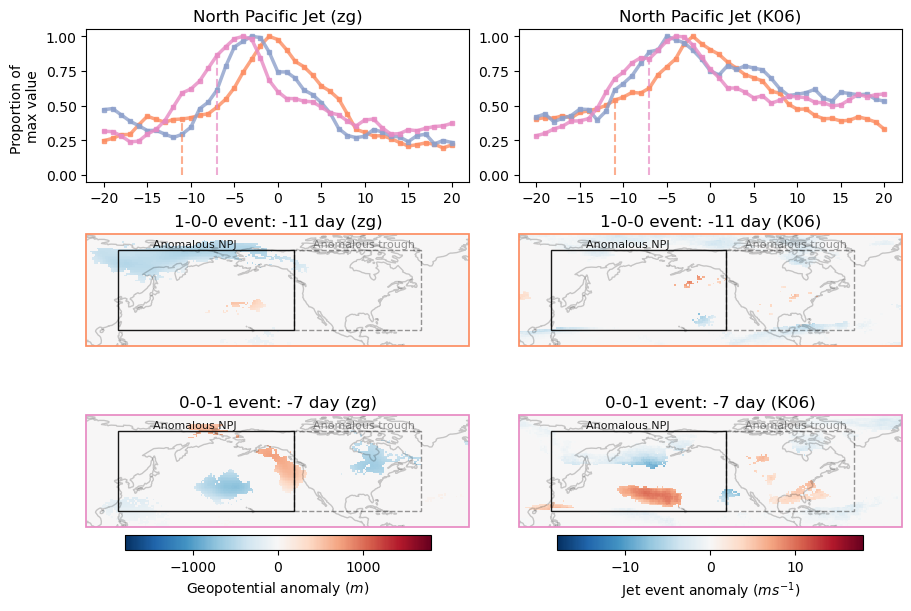

In [125]:
# ONSETS as determined by above 0.6 of max threshold
npj_onset_100 = -11
npj_onset_001 = -7

fig = plt.figure(figsize=(9, 6), constrained_layout=True) #9, 5 best ratio
gs = plt.GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
for ind, col in enumerate(trough_prop_df.columns):
    ax1.plot(np.arange(-20, 21), npj_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8, marker='s', markersize=3)
    ax2.plot(np.arange(-20, 21), npj_prop_df_jet[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8 , marker='s', markersize=3)

ax1.set_title("North Pacific Jet (zg)")
ax2.set_title("North Pacific Jet (K06)")
ax1.set_ylabel("Proportion of \nmax value", size=10)

ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax4 = fig.add_subplot(gs[1, 1], projection=proj, sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], projection=proj, sharex=ax3, sharey=ax3)
ax6 = fig.add_subplot(gs[2, 1], projection=proj, sharex=ax3, sharey=ax3)

plot_lag_composite_zg('100', npj_onset_100, ax3, vmin=-1800, vmax=1800)
plot_lag_composite_zg('001', npj_onset_001, ax5, vmin=-1800, vmax=1800, cbar=True)
plot_lag_composite('100', npj_onset_100, ax4, cbar=False)
plot_lag_composite('001', npj_onset_001, ax6, cbar=True)


ax1.vlines(x=npj_onset_100, ymin=0., ymax=npj_prop_df.iloc[20+npj_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=npj_onset_001, ymin=0., ymax=npj_prop_df.iloc[20+npj_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)
ax2.vlines(x=npj_onset_100, ymin=0., ymax=npj_prop_df_jet.iloc[20+npj_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax2.vlines(x=npj_onset_001, ymin=0., ymax=npj_prop_df_jet.iloc[20+npj_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)


for ind, ax in enumerate([ax3, ax4, ax5, ax6]):
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.coastlines(alpha=.2)
    if ind > 1:
        ax.spines['geo'].set_edgecolor(set2_cmap[3])
    else:
        ax.spines['geo'].set_edgecolor(set2_cmap[1])
    ax.spines['geo'].set_linewidth(1.25)
    npj_box_alpha = .9
    trough_box_alpha = .4
    
        
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
    
# ax3.set_title(f"1-0-0 {npj_onset_100} day composite (zg)")#, color=set2_cmap[1])
# ax4.set_title(f"1-0-0 {npj_onset_100} day composite (K06)")#, color=set2_cmap[1])
# ax5.set_title(f"0-0-1 {npj_onset_001} day composite (zg)")#, color=set2_cmap[3])
# ax6.set_title(f"0-0-1 {npj_onset_001} day composite (K06)")#, color=set2_cmap[3])

ax3.set_title(f"1-0-0 event: {npj_onset_100} day (zg)")#, color=set2_cmap[1])
ax4.set_title(f"1-0-0 event: {npj_onset_100} day (K06)")#, color=set2_cmap[1])
ax5.set_title(f"0-0-1 event: {npj_onset_001} day (zg)")#, color=set2_cmap[3])
ax6.set_title(f"0-0-1 event: {npj_onset_001} day (K06)")#, color=set2_cmap[3])

# fig.savefig("figures/zgvsjet_NPJ_timings_before.png", bbox_inches='tight', dpi=300)

#### Get first value above threshold

In [126]:
npj_prop_df['lag'] = np.arange(-20, 21)
npj_prop_df_jet['lag'] = np.arange(-20, 21)

In [127]:
k06_npj_prop_above_threshold = {}
zg_npj_prop_above_threshold = {}
for outbreak_type in ['100', '010', '001']:
    k06_npj_prop_above_threshold[outbreak_type] = {}
    zg_npj_prop_above_threshold[outbreak_type] = {}

    for threshold in [0.9, 0.8, 0.7, 0.6, 0.5]:
        k06_npj_prop_above_threshold[outbreak_type][threshold] = npj_prop_df_jet[npj_prop_df_jet[outbreak_type] > threshold].iloc[0]['lag']
        zg_npj_prop_above_threshold[outbreak_type][threshold] = npj_prop_df[npj_prop_df[outbreak_type] > threshold].iloc[0]['lag']


In [128]:
k06_npj_prop_above_threshold_df = pd.DataFrame(k06_npj_prop_above_threshold)
zg_npj_prop_above_threshold_df = pd.DataFrame(zg_npj_prop_above_threshold)

In [129]:
zg_npj_prop_above_threshold_df

100  010   001
0.9 -2.0 -5.0  -6.0
0.8 -3.0 -5.0  -7.0
0.7 -4.0 -6.0  -8.0
0.6 -5.0 -7.0 -10.0
0.5 -6.0 -8.0 -11.0

In [130]:
k06_npj_prop_above_threshold_df

100   010   001
0.9  -3.0  -6.0  -6.0
0.8  -4.0  -8.0  -9.0
0.7  -6.0  -9.0 -10.0
0.6  -7.0 -11.0 -11.0
0.5 -12.0 -11.0 -12.0

In [131]:
diff_npj_prop_above_threshold_df = k06_npj_prop_above_threshold_df - zg_npj_prop_above_threshold_df
diff_npj_prop_above_threshold_df.columns = ['W', 'C', 'E']

<Axes: >

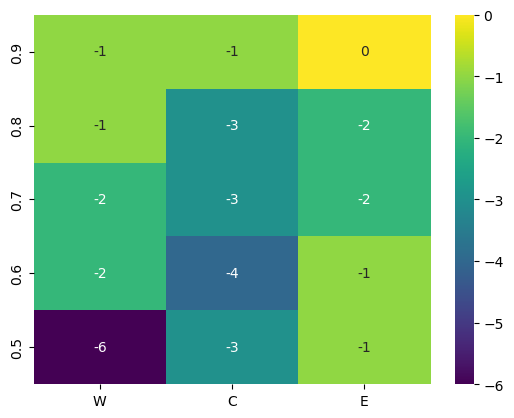

In [132]:
sns.heatmap(diff_npj_prop_above_threshold_df, annot=True, cmap='viridis')


W 0
C 1
E 2


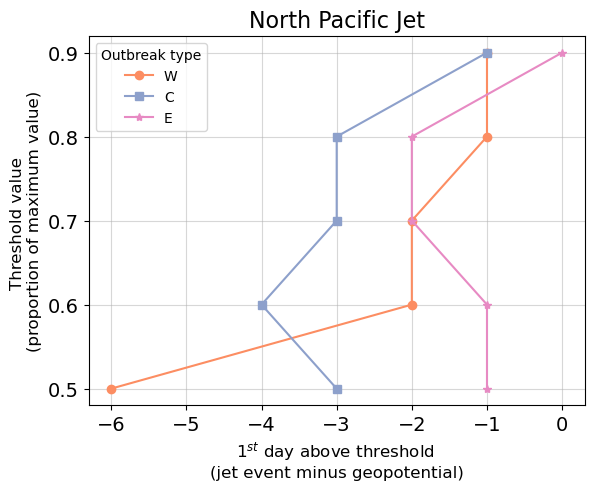

In [133]:
fig, ax = plt.subplots(1) 
# Plot each column with values on x-axis and thresholds (index) on y-axis 
marker_types = ['o', 's', '*']
for ind, col in enumerate(diff_npj_prop_above_threshold_df.columns):
    print(col, ind)
    ax.plot(diff_npj_prop_above_threshold_df[col], diff_npj_prop_above_threshold_df.index, marker=marker_types[ind], label=col, color=set2_cmap[ind+1])
ax.grid(axis='both', alpha=.5)
ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], size=14)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9], [0.5, 0.6, 0.7, 0.8, 0.9], size=14)
ax.set_xlabel("$1^{st}$ day above threshold \n(jet event minus geopotential)", size=12)
ax.set_ylabel("Threshold value \n(proportion of maximum value)", size=12)
ax.set_title("North Pacific Jet", size=16)
ax.legend(['W', 'C', 'E'], title='Outbreak type')
# fig.savefig("figures/comparision_of_prop_of_max_thresholds_npj", bbox_inches='tight', dpi=200)


Text(0.5, 1.06, 'North Pacific jet')

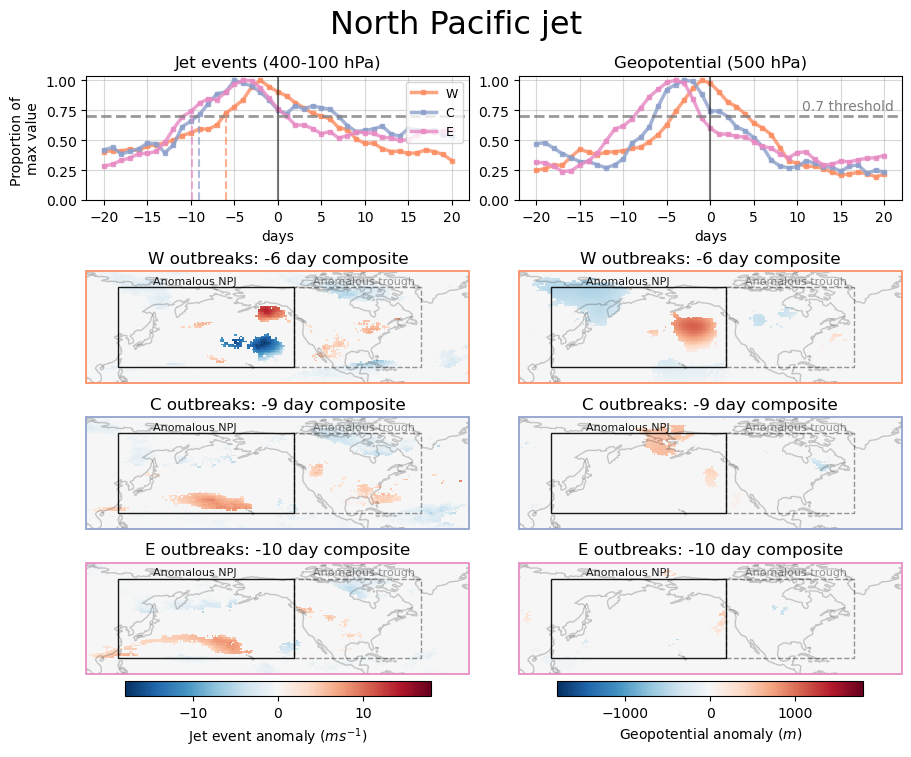

In [134]:
# ONSETS as determined by above 0.6 of max threshold
SAME_SIGN_THRESHOLD = 0.66
npj_onset_100 = -6
npj_onset_010 = -9
npj_onset_001 = -10

fig = plt.figure(figsize=(9, 7), constrained_layout=True) #9, 5 best ratio
gs = plt.GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
for ind, col in enumerate(npj_prop_df.columns[:3]):
    ax1.plot(np.arange(-20, 21), npj_prop_df_jet[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8 , marker='s', markersize=3)
    ax2.plot(np.arange(-20, 21), npj_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8, marker='s', markersize=3)

for ind, ax in enumerate([ax1, ax2]):
    ax.grid(axis='both', alpha=.5)
    ax.axvline(0, color='k', alpha=.5)
    if ind == 0:
        ax.legend(['W', 'C', 'E'], loc=1, fontsize=9)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_ylim(0.0, 1.04)
    ax.set_xlabel("days")
    
ax1.set_title("Jet events (400-100 hPa)")
ax1.set_ylabel("Proportion of \nmax value", size=10)
ax2.set_title("Geopotential (500 hPa)")

ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax4 = fig.add_subplot(gs[1, 1], projection=proj, sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], projection=proj, sharex=ax3, sharey=ax3)
ax6 = fig.add_subplot(gs[2, 1], projection=proj, sharex=ax3, sharey=ax3)
ax7 = fig.add_subplot(gs[3, 0], projection=proj, sharex=ax3, sharey=ax3)
ax8 = fig.add_subplot(gs[3, 1], projection=proj, sharex=ax3, sharey=ax3)

plot_lag_composite('100', npj_onset_100, ax3, cbar=False)
plot_lag_composite_zg('100', npj_onset_100, ax4, vmin=-2000, vmax=2000)
plot_lag_composite('010', npj_onset_010, ax5, cbar=False)
plot_lag_composite_zg('010', npj_onset_010, ax6, vmin=-2000, vmax=2000, cbar=False)
plot_lag_composite('001', npj_onset_001, ax7, cbar=True)
plot_lag_composite_zg('001', npj_onset_001, ax8, vmin=-1800, vmax=1800, cbar=True)


ax1.axhline(0.7, linestyle='--', color='grey', alpha=.8, linewidth=2)
ax2.axhline(0.7, linestyle='--', color='grey', alpha=.8, linewidth=2)
ax2.text(s="0.7 threshold", x=10.5, y=0.75, color='grey')

ax1.vlines(x=npj_onset_100, ymin=0., ymax=npj_prop_df_jet.iloc[20+npj_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=npj_onset_010-0.1, ymin=0., ymax=npj_prop_df_jet.iloc[20+npj_onset_010]['010'],\
           color=set2_cmap[2], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=npj_onset_001+0.1, ymin=0., ymax=npj_prop_df_jet.iloc[20+npj_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)

# ax2.vlines(x=npj_onset_100, ymin=0., ymax=npj_prop_df.iloc[20+npj_onset_100]['100'],\
#            color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=npj_onset_010-0.1, ymin=0., ymax=npj_prop_df_jet.iloc[20+npj_onset_010]['010'],\
#            color=set2_cmap[2], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=npj_onset_001+0.1, ymin=0., ymax=npj_prop_df.iloc[20+npj_onset_001]['001'],\
#            color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)

for ind, ax in enumerate([ax3, ax4, ax5, ax6, ax7, ax8]):
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.coastlines(alpha=.2)
    if ind == 0 or ind == 1:
        ax.spines['geo'].set_edgecolor(set2_cmap[1])
    elif ind == 2 or ind == 3:
        ax.spines['geo'].set_edgecolor(set2_cmap[2])
    else:
        ax.spines['geo'].set_edgecolor(set2_cmap[3])
    ax.spines['geo'].set_linewidth(1.25)
    npj_box_alpha = .9
    trough_box_alpha = .4
    
        
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
    
ax3.set_title(f"W outbreaks: {npj_onset_100} day composite")#, color=set2_cmap[1])
ax4.set_title(f"W outbreaks: {npj_onset_100} day composite")#, color=set2_cmap[1])
ax5.set_title(f"C outbreaks: {npj_onset_010} day composite")#, color=set2_cmap[3])
ax6.set_title(f"C outbreaks: {npj_onset_010} day composite")#, color=set2_cmap[3])
ax7.set_title(f"E outbreaks: {npj_onset_001} day composite")#, color=set2_cmap[3])
ax8.set_title(f"E outbreaks: {npj_onset_001} day composite")#, color=set2_cmap[3])

fig.suptitle('North Pacific jet', size=23, y=1.06)

# fig.savefig("figures/zgvsjet_NPJ_timings_66pnt_pnt7thresh.png", bbox_inches='tight', dpi=300)

In [135]:
trough_prop_df['lag'] = np.arange(-20, 21)
trough_prop_df_jet['lag'] = np.arange(-20, 21)

In [136]:
k06_trough_prop_above_threshold = {}
zg_trough_prop_above_threshold = {}
for outbreak_type in ['100', '010', '001']:
    k06_trough_prop_above_threshold[outbreak_type] = {}
    zg_trough_prop_above_threshold[outbreak_type] = {}

    for threshold in [0.9, 0.8, 0.7, 0.6, 0.5]:
        k06_trough_prop_above_threshold[outbreak_type][threshold] = trough_prop_df_jet[trough_prop_df_jet[outbreak_type] > threshold].iloc[0]['lag']
        zg_trough_prop_above_threshold[outbreak_type][threshold] = trough_prop_df[trough_prop_df[outbreak_type] > threshold].iloc[0]['lag']


In [137]:
k06_trough_prop_above_threshold_df = pd.DataFrame(k06_trough_prop_above_threshold)
zg_trough_prop_above_threshold_df = pd.DataFrame(zg_trough_prop_above_threshold)

In [138]:
zg_trough_prop_above_threshold_df

100   010  001
0.9 -1.0  -2.0 -2.0
0.8 -1.0  -3.0 -3.0
0.7 -2.0  -4.0 -4.0
0.6 -3.0  -5.0 -5.0
0.5 -3.0 -11.0 -6.0

In [139]:
k06_trough_prop_above_threshold_df

100  010  001
0.9 -1.0 -1.0 -2.0
0.8 -1.0 -2.0 -2.0
0.7 -2.0 -3.0 -3.0
0.6 -2.0 -4.0 -4.0
0.5 -3.0 -5.0 -5.0

In [140]:
diff_trough_prop_above_threshold_df = k06_trough_prop_above_threshold_df - zg_trough_prop_above_threshold_df
diff_trough_prop_above_threshold_df.columns = ['W', 'C', 'E']

<Axes: >

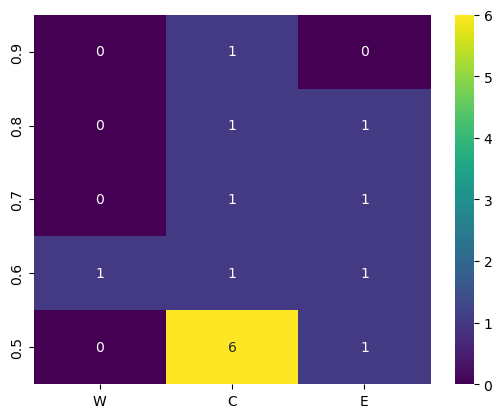

In [141]:
sns.heatmap(diff_trough_prop_above_threshold_df, annot=True, cmap='viridis')


W 0
C 1
E 2


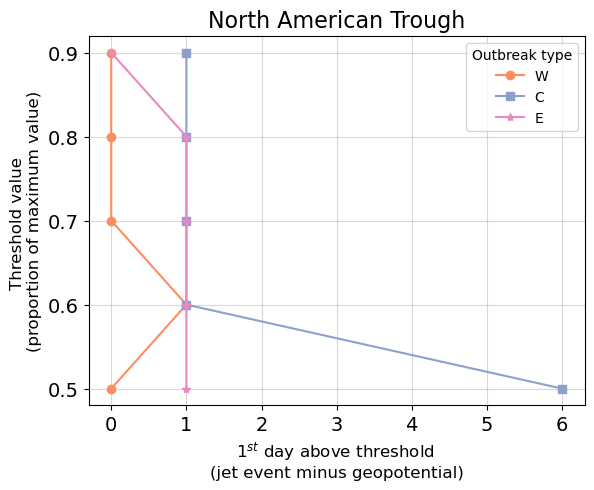

In [142]:
fig, ax = plt.subplots(1) 
# Plot each column with values on x-axis and thresholds (index) on y-axis 
marker_types = ['o', 's', '*']
for ind, col in enumerate(diff_trough_prop_above_threshold_df.columns):
    print(col, ind)
    ax.plot(diff_trough_prop_above_threshold_df[col], diff_trough_prop_above_threshold_df.index, marker=marker_types[ind], label=col, color=set2_cmap[ind+1])
ax.grid(axis='both', alpha=.5)
ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], size=14)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9], [0.5, 0.6, 0.7, 0.8, 0.9], size=14)
ax.set_xlabel("$1^{st}$ day above threshold \n(jet event minus geopotential)", size=12)
ax.set_ylabel("Threshold value \n(proportion of maximum value)", size=12)
ax.set_title("North American Trough", size=16)
ax.legend(['W', 'C', 'E'], title='Outbreak type')
# fig.savefig("figures/comparision_of_prop_of_max_thresholds_trough", bbox_inches='tight', dpi=200)


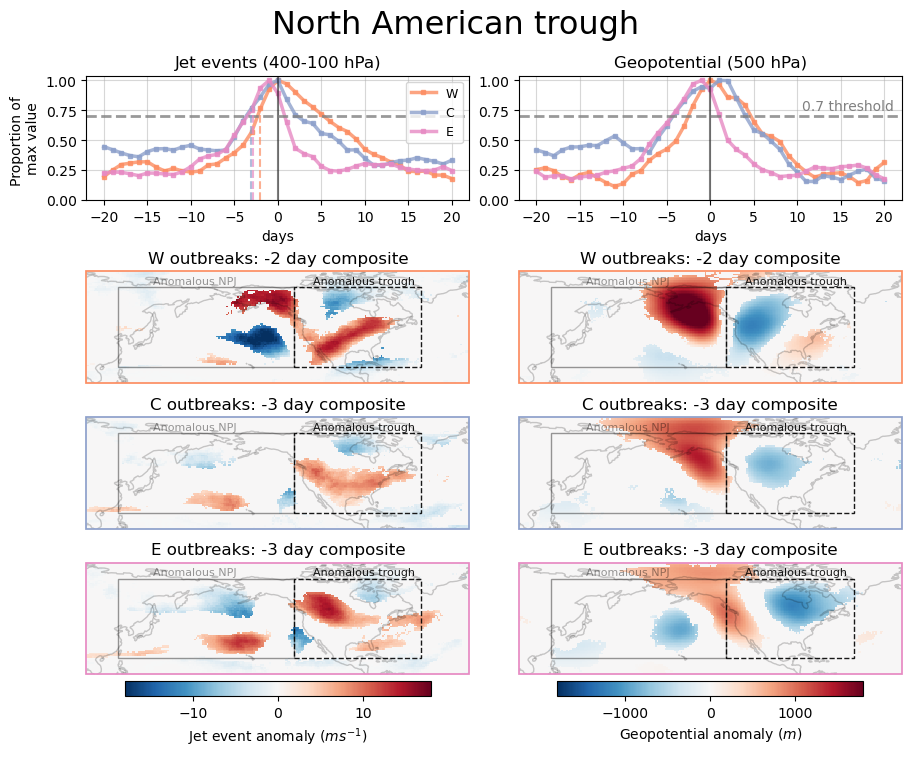

In [143]:
# ONSETS as determined by above 0.6 of max threshold
SAME_SIGN_THRESHOLD = 0.66
trough_onset_100 = -2
trough_onset_010 = -3
trough_onset_001 = -3


fig = plt.figure(figsize=(9, 7), constrained_layout=True) #9, 5 best ratio
gs = plt.GridSpec(4, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
for ind, col in enumerate(trough_prop_df.columns[:3]):
    ax1.plot(np.arange(-20, 21), trough_prop_df_jet[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8 , marker='s', markersize=3)
    ax2.plot(np.arange(-20, 21), trough_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8, marker='s', markersize=3)
    

for ind, ax in enumerate([ax1, ax2]):
    ax.grid(axis='both', alpha=.5)
    ax.axvline(0, color='k', alpha=.5)
    if ind == 0:
        ax.legend(['W', 'C', 'E'], fontsize=9)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_ylim(0.0, 1.04)
    ax.set_xlabel("days")

ax1.set_ylabel("Proportion of \nmax value", size=10)
ax1.set_title("Jet events (400-100 hPa)")    
ax2.set_title("Geopotential (500 hPa)")

ax1.axhline(0.7, linestyle='--', color='grey', alpha=.8, linewidth=2)
ax2.axhline(0.7, linestyle='--', color='grey', alpha=.8, linewidth=2)
ax2.text(s="0.7 threshold", x=10.5, y=0.75, color='grey')

ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax4 = fig.add_subplot(gs[1, 1], projection=proj, sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], projection=proj, sharex=ax3, sharey=ax3)
ax6 = fig.add_subplot(gs[2, 1], projection=proj, sharex=ax3, sharey=ax3)
ax7 = fig.add_subplot(gs[3, 0], projection=proj, sharex=ax3, sharey=ax3)
ax8 = fig.add_subplot(gs[3, 1], projection=proj, sharex=ax3, sharey=ax3)

plot_lag_composite('100', trough_onset_100, ax3, cbar=False)
plot_lag_composite_zg('100', trough_onset_100, ax4, vmin=-1800, vmax=1800)

plot_lag_composite('010', trough_onset_010, ax5, cbar=False)
plot_lag_composite_zg('010', trough_onset_010, ax6, vmin=-1800, vmax=1800, cbar=False)

plot_lag_composite('001', trough_onset_001, ax7, cbar=True)
plot_lag_composite_zg('001', trough_onset_001, ax8, vmin=-1800, vmax=1800, cbar=True)


ax1.vlines(x=trough_onset_100, ymin=0., ymax=trough_prop_df_jet.iloc[20+trough_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=trough_onset_010-0.1, ymin=0., ymax=trough_prop_df_jet.iloc[20+trough_onset_010]['010'],\
           color=set2_cmap[2], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=trough_onset_001+0.1, ymin=0., ymax=trough_prop_df_jet.iloc[20+trough_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)

# ax2.vlines(x=trough_onset_100, ymin=0., ymax=trough_prop_df.iloc[20+trough_onset_100]['100'],\
#            color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=trough_onset_010-0.1, ymin=0., ymax=trough_prop_df_jet.iloc[20+trough_onset_010]['010'],\
#            color=set2_cmap[2], linestyle='--', linewidth=1.5, alpha=.7)
# ax2.vlines(x=trough_onset_001+0.1, ymin=0., ymax=trough_prop_df.iloc[20+trough_onset_001]['001'],\
#            color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)


for ind, ax in enumerate([ax3, ax4, ax5, ax6, ax7, ax8]):
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.coastlines(alpha=.2)
    if ind == 0 or ind == 1:
        ax.spines['geo'].set_edgecolor(set2_cmap[1])
    elif ind == 2 or ind == 3:
        ax.spines['geo'].set_edgecolor(set2_cmap[2])
    else:
        ax.spines['geo'].set_edgecolor(set2_cmap[3])
    ax.spines['geo'].set_linewidth(1.25)
    npj_box_alpha = .4
    trough_box_alpha = .9
    
        
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
    
ax3.set_title(f"W outbreaks: {trough_onset_100} day composite")#, color=set2_cmap[1])
ax4.set_title(f"W outbreaks: {trough_onset_100} day composite")#, color=set2_cmap[1])
ax5.set_title(f"C outbreaks: {trough_onset_010} day composite")#, color=set2_cmap[3])
ax6.set_title(f"C outbreaks: {trough_onset_010} day composite")#, color=set2_cmap[3])
ax7.set_title(f"E outbreaks: {trough_onset_001} day composite")#, color=set2_cmap[3])
ax8.set_title(f"E outbreaks: {trough_onset_001} day composite")#, color=set2_cmap[3])

fig.suptitle('North American trough', size=23, y=1.06)
# fig.savefig("figures/zgvsjet_Trough_timings_66pnt_pnt7thresh.png", bbox_inches='tight', dpi=300)

In [ ]:
# ONSETS as determined by above 0.6 of max threshold
npj_onset_100 = -5
npj_onset_001 = -9
trough_onset_100 = -4
trough_onset_001 = -2

fig = plt.figure(figsize=(9, 6), constrained_layout=True) #9, 5 best ratio
gs = plt.GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
for ind, col in enumerate(trough_prop_df.columns):
    ax1.plot(np.arange(-20, 21), trough_prop_df[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8, marker='s', markersize=3)
    ax2.plot(np.arange(-20, 21), trough_prop_df_jet[col], linewidth=2.5, color=set2_cmap[ind+1], alpha=.8 , marker='s', markersize=3)

ax1.set_title("North American Trough (zg)")
ax2.set_title("North American Trough (K06)")
ax1.set_ylabel("Proportion of \nmax value", size=10)

ax3 = fig.add_subplot(gs[1, 0], projection=proj)
ax4 = fig.add_subplot(gs[1, 1], projection=proj, sharex=ax3, sharey=ax3)
ax5 = fig.add_subplot(gs[2, 0], projection=proj, sharex=ax3, sharey=ax3)
ax6 = fig.add_subplot(gs[2, 1], projection=proj, sharex=ax3, sharey=ax3)

plot_lag_composite_zg('100', trough_onset_100, ax3, vmin=-1800, vmax=1800)
plot_lag_composite_zg('001', trough_onset_001, ax5, vmin=-1800, vmax=1800, cbar=True)
plot_lag_composite('100', trough_onset_100, ax4, cbar=False)
plot_lag_composite('001', trough_onset_001, ax6, cbar=True)


ax1.vlines(x=trough_onset_100, ymin=0., ymax=trough_prop_df.iloc[20+trough_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax1.vlines(x=trough_onset_001, ymin=0., ymax=trough_prop_df.iloc[20+trough_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)
ax2.vlines(x=trough_onset_100, ymin=0., ymax=trough_prop_df_jet.iloc[20+trough_onset_100]['100'],\
           color=set2_cmap[1], linestyle='--', linewidth=1.5, alpha=.7)
ax2.vlines(x=trough_onset_001, ymin=0., ymax=trough_prop_df_jet.iloc[20+trough_onset_001]['001'],\
           color=set2_cmap[3], linestyle='--', linewidth=1.5, alpha=.7)


for ind, ax in enumerate([ax3, ax4, ax5, ax6]):
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.coastlines(alpha=.2)
    if ind > 1:
        ax.spines['geo'].set_edgecolor(set2_cmap[3])
    else:
        ax.spines['geo'].set_edgecolor(set2_cmap[1])
    ax.spines['geo'].set_linewidth(1.25)
    npj_box_alpha = .4
    trough_box_alpha = .9
    
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
    
ax3.set_title(f"WNA {trough_onset_100} day composite (zg)")#, color=set2_cmap[1])
ax4.set_title(f"WNA {trough_onset_100} day composite (zg)")#, color=set2_cmap[1])
ax5.set_title(f"ENA {trough_onset_001} day composite (K06)")#, color=set2_cmap[3])
ax6.set_title(f"ENA {trough_onset_001} day composite (K06)")#, color=set2_cmap[3])

# fig.savefig("figures/zgvsjet_trough_timings.png", bbox_inches='tight', dpi=300)

In [ ]:
counter=1
for i in range(-20, 21):
    fig, ax = plt.subplots(1, subplot_kw={'projection':proj})
    plot_lag_composite_zg('100', i, ax, vmin=-1800, vmax=1800, cbar=True)
    ax.coastlines()
    ax.set_extent([100, 340, 10, 80], crs=box_proj)
    ax.set_title(f'WNA ZG lag={i} days')
    ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=npj_box_alpha)
 
    ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                facecolor='none', edgecolor='k', alpha=npj_box_alpha,
                                transform=ccrs.PlateCarree()))
    ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=trough_box_alpha)
    ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=80, height=50,
                                facecolor='none', linestyle='--',
                                    edgecolor='k', alpha=trough_box_alpha,
                                transform=ccrs.PlateCarree()))
    # fig.savefig(f'figures/zg_composites/ORD{counter}_zg_WNA_DJF_{i}lag.png', bbox_inches='tight')
    plt.show()
    counter +=1


In [ ]:
counter = 1
for i in range(-20, 21):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection':proj})
    ax1, ax2 = axes
    plot_lag_composite('100', i, ax1, cbar=True)
    plot_lag_composite_zg('100', i, ax2, vmin=-1800, vmax=1800, cbar=True)

    for ax in axes:
        ax.coastlines()
        ax.set_extent([100, 340, 10, 80], crs=box_proj)
        ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=.8)

        ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                    facecolor='none', edgecolor='k', alpha=.5,
                                    transform=ccrs.PlateCarree()))
        ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=.8)
        ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=100, height=50,
                                    facecolor='none', linestyle='--',
                                        edgecolor='k', alpha=.5,
                                    transform=ccrs.PlateCarree()))
    ax1.set_title(f'WNA Jet lag={i} days')
    ax2.set_title(f'WNA ZG lag={i} days')
    # fig.savefig(f'figures/jet_zg_composites/ORD{counter}_jet_and_zg_WNA_DJF_{i}lag.png', bbox_inches='tight')
    plt.show()
    counter += 1


In [ ]:
counter = 1
for i in range(-20, 21):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection':proj})
    ax1, ax2 = axes
    plot_lag_composite('010', i, ax1, cbar=True)
    plot_lag_composite_zg('010', i, ax2, vmin=-1800, vmax=1800, cbar=True)

    for ax in axes:
        ax.coastlines()
        ax.set_extent([100, 340, 10, 80], crs=box_proj)
        ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=.8)

        ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                    facecolor='none', edgecolor='k', alpha=.5,
                                    transform=ccrs.PlateCarree()))
        ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=.8)
        ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=100, height=50,
                                    facecolor='none', linestyle='--',
                                        edgecolor='k', alpha=.5,
                                    transform=ccrs.PlateCarree()))
    ax1.set_title(f'CNA Jet lag={i} days')
    ax2.set_title(f'CNA ZG lag={i} days')
    # fig.savefig(f'figures/jet_zg_composites/ORD{counter}_jet_and_zg_CNA_DJF_{i}lag.png', bbox_inches='tight')
    plt.show()
    counter +=1


In [ ]:
counter = 1
for i in range(-20, 21):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection':proj})
    ax1, ax2 = axes
    plot_lag_composite('001', i, ax1, cbar=True)
    plot_lag_composite_zg('001', i, ax2, vmin=-1800, vmax=1800, cbar=True)

    for ax in axes:
        ax.coastlines()
        ax.set_extent([100, 340, 10, 80], crs=box_proj)
        ax.text(s="Anomalous NPJ", x=142, y=72, size=8, transform=ccrs.PlateCarree(), alpha=.8)

        ax.add_patch(mpatches.Rectangle(xy=[120, 20], width=110, height=50,
                                    facecolor='none', edgecolor='k', alpha=.5,
                                    transform=ccrs.PlateCarree()))
        ax.text(s="Anomalous trough", x=242, y=72, size=8, transform=ccrs.PlateCarree(), alpha=.8)
        ax.add_patch(mpatches.Rectangle(xy=[230, 20], width=100, height=50,
                                    facecolor='none', linestyle='--',
                                        edgecolor='k', alpha=.5,
                                    transform=ccrs.PlateCarree()))
    ax1.set_title(f'ENA Jet lag={i} days')
    ax2.set_title(f'ENA ZG lag={i} days')
    # fig.savefig(f'figures/jet_zg_composites/ORD{counter}_jet_and_zg_ENA_DJF_{i}lag.png', bbox_inches='tight')
    plt.show()
    counter+=1
